#⛹️‍♂️NBA Data Analysis
Grupo:
  - Amanda Moraes (ascm)
  - Tales Alves (tta)

Dataset: https://www.kaggle.com/datasets/justinas/nba-players-data

Outras fontes de dados: https://www.basketball-reference.com/ 

##✅Passo a passo
* Coletar dados ✔
  - Extrair mais dados da web ✔
* Pré-processamento dos dados
  - Definição de tipos ✔
  - Tratamento de dados ausentes ✔
  - Normalização e discretização
  - Limpeza de dados/remoção de outliers
* Apresentar estatísticas descritivas utilizando visualizações
* Realizar testes de hipóteses para comparação dos valores de categorias e visualizar diferenças

##🗂️Dependencias

In [1]:
! pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 9.5 MB/s 


In [127]:
import pandas as pd
import numpy as np
import re
from urllib.request import urlopen
from bs4 import BeautifulSoup
from unidecode import unidecode
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
from sklearn import preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##🎲Carregar dados iniciais

In [ ]:
# Path Amanda
data_path = '/content/drive/MyDrive/facul/2022.1/TAGDI/projeto1/data/all_seasons.csv'

In [ ]:
# Path Tales
data_path = '/content/drive/MyDrive/2022.1/TA GDI/projeto1/data/all_seasons.csv'

In [ ]:
df = pd.read_csv(data_path)

In [ ]:
df.tail()

Unnamed: 0          player_name team_abbreviation   age  player_height  \
11695       11695  Matthew Dellavedova               CLE  30.0         190.50   
11696       11696     Maurice Harkless               SAC  28.0         200.66   
11697       11697            Max Strus               MIA  25.0         195.58   
11698       11698    Marcus Morris Sr.               LAC  31.0         203.20   
11699       11699         Aaron Gordon               DEN  25.0         203.20   

       player_weight                          college    country draft_year  \
11695      90.718400  St.Mary's College of California  Australia  Undrafted   
11696      99.790240                       St. John's        USA       2012   
11697      97.522280                           DePaul        USA  Undrafted   
11698      98.883056                           Kansas        USA       2011   
11699     106.594120                          Arizona        USA       2014   

      draft_round  ...   pts  reb  ast  net_rating  oreb_pct  dreb_pct  \
11695   Undrafted  ...   2.8  1.8  4.5        -3.1     0.029     0.085   
11696           1  ...   5.2  2.4  1.2        -2.9     0.017     0.097   
11697   Undrafted  ...   6.1  1.1  0.6        -4.2     0.011     0.073   
11698           1  ...  13.4  4.1  1.0         4.2     0.025     0.133   
11699           1  ...  12.4  5.7  3.2         2.1     0.055     0.150   

       usg_pct  ts_pct  ast_pct   season  
11695    0.125   0.312    0.337  2020-21  
11696    0.114   0.527    0.071  2020-21  
11697    0.179   0.597    0.074  2020-21  
11698    0.194   0.614    0.056  2020-21  
11699    0.204   0.547    0.165  2020-21  

[5 rows x 22 columns]

In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df.dtypes

player_name           object
team_abbreviation     object
age                  float64
player_height        float64
player_weight        float64
college               object
country               object
draft_year            object
draft_round           object
draft_number          object
gp                     int64
pts                  float64
reb                  float64
ast                  float64
net_rating           float64
oreb_pct             float64
dreb_pct             float64
usg_pct              float64
ts_pct               float64
ast_pct              float64
season                object
dtype: object

##➕Acrescentar dados
- Não encontramos na base de dados do Kaggle os dados da última temporada da NBA, portanto, fomos em busca desses dados mais recentes no site [Basketball Reference](https://www.basketball-reference.com)
- Boa parte das colunas faltantes podem ser encontradas em diferentes tabelas e nas páginas individuais dos jogadores (como país de origem, faculdade etc)

###📅Per Game Table
Para obter:
- Nome, time, idade, jogos, pontos, rebotes, assistências e temporada

In [ ]:
df_new = pd.read_html('https://www.basketball-reference.com/leagues/NBA_2022_per_game.html', header=0)[0]

In [ ]:
df_new.tail()

Rk          Player Pos Age   Tm   G  GS    MP   FG   FGA  ...   FT%  \
837  601  Thaddeus Young  PF  33  TOR  26   0  18.3  2.6   5.5  ...  .481   
838  602      Trae Young  PG  23  ATL  76  76  34.9  9.4  20.3  ...  .904   
839  603  Omer Yurtseven   C  23  MIA  56  12  12.6  2.3   4.4  ...  .623   
840  604     Cody Zeller   C  29  POR  27   0  13.1  1.9   3.3  ...  .776   
841  605     Ivica Zubac   C  24  LAC  76  76  24.4  4.1   6.5  ...  .727   

     ORB  DRB  TRB  AST  STL  BLK  TOV   PF   PTS  
837  1.5  2.9  4.4  1.7  1.2  0.4  0.8  1.7   6.3  
838  0.7  3.1  3.7  9.7  0.9  0.1  4.0  1.7  28.4  
839  1.5  3.7  5.3  0.9  0.3  0.4  0.7  1.5   5.3  
840  1.9  2.8  4.6  0.8  0.3  0.2  0.7  2.1   5.2  
841  2.9  5.6  8.5  1.6  0.5  1.0  1.5  2.7  10.3  

[5 rows x 30 columns]

In [ ]:
df_new.shape

(842, 30)

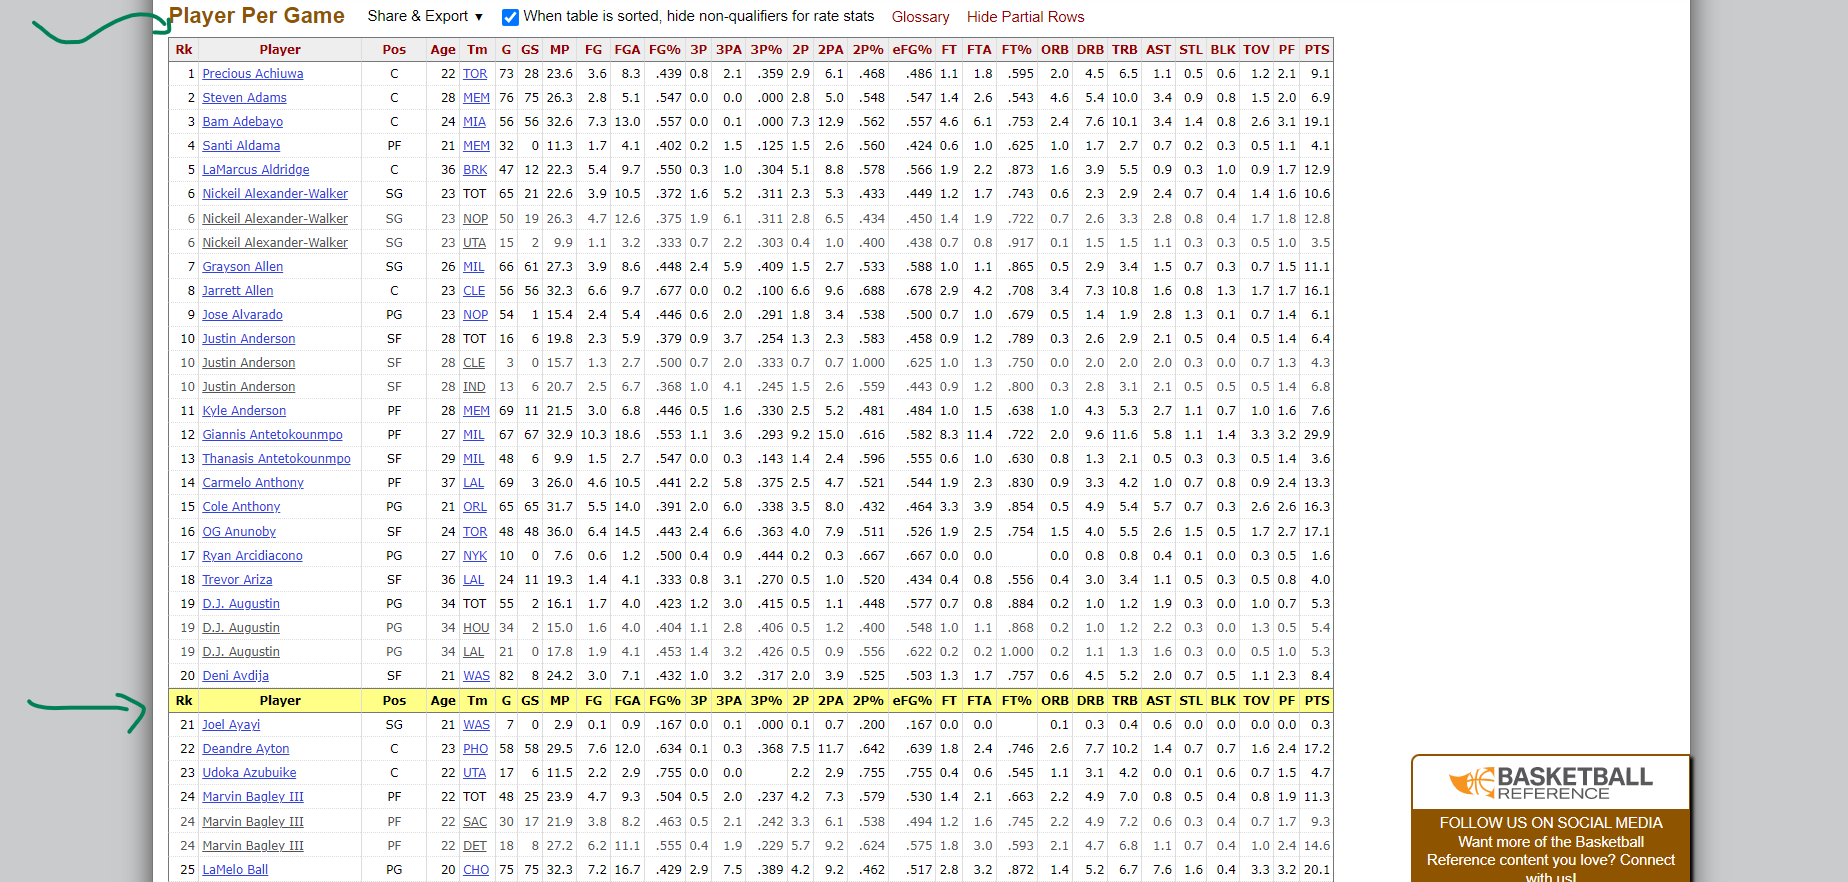

A tabela lida do endereço acima tem algumas linhas de títulos intercaladas com as linhas de dados propriamente ditos, como na imagem acima, por isso elas serão removidas:

In [ ]:
df_new = df_new[df_new.Rk != 'Rk']

In [ ]:
df_new.shape

(812, 30)

In [ ]:
df_new.reset_index(drop=True, inplace=True)

In [ ]:
df_new.drop(columns=['Rk'], inplace=True)

**Renomeando colunas** dos dados obtidos da tabela Per Game para corresponder às suas equivalentes do dataset inicial:

In [ ]:
print(df.columns, '\n\n', df_new.columns)

Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object') 

 Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')


In [ ]:
df_new.rename(columns={'Player': 'player_name', 'Age': 'age', 'Tm': 'team_abbreviation', 'G': 'gp', 'TRB': 'reb', 'AST': 'ast', 'PTS': 'pts'}, inplace=True)
df_new.head()

player_name Pos age team_abbreviation  gp  GS    MP   FG   FGA   FG%  \
0   Precious Achiuwa   C  22               TOR  73  28  23.6  3.6   8.3  .439   
1       Steven Adams   C  28               MEM  76  75  26.3  2.8   5.1  .547   
2        Bam Adebayo   C  24               MIA  56  56  32.6  7.3  13.0  .557   
3       Santi Aldama  PF  21               MEM  32   0  11.3  1.7   4.1  .402   
4  LaMarcus Aldridge   C  36               BRK  47  12  22.3  5.4   9.7  .550   

   ...   FT%  ORB  DRB   reb  ast  STL  BLK  TOV   PF   pts  
0  ...  .595  2.0  4.5   6.5  1.1  0.5  0.6  1.2  2.1   9.1  
1  ...  .543  4.6  5.4  10.0  3.4  0.9  0.8  1.5  2.0   6.9  
2  ...  .753  2.4  7.6  10.1  3.4  1.4  0.8  2.6  3.1  19.1  
3  ...  .625  1.0  1.7   2.7  0.7  0.2  0.3  0.5  1.1   4.1  
4  ...  .873  1.6  3.9   5.5  0.9  0.3  1.0  0.9  1.7  12.9  

[5 rows x 29 columns]

**Removendo colunas** dos dados obtidos da tabela Per Game que não têm equivalentes no dataset inicial:

In [ ]:
df_new.drop(columns=['Pos', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 
                     'DRB', 'STL', 'BLK', 'TOV', 'PF'], inplace=True)
df_new.tail()

player_name age team_abbreviation  gp  reb  ast   pts
807  Thaddeus Young  33               TOR  26  4.4  1.7   6.3
808      Trae Young  23               ATL  76  3.7  9.7  28.4
809  Omer Yurtseven  23               MIA  56  5.3  0.9   5.3
810     Cody Zeller  29               POR  27  4.6  0.8   5.2
811     Ivica Zubac  24               LAC  76  8.5  1.6  10.3

**Reordenando colunas**

In [ ]:
cols = df_new.columns.tolist()
cols = [cols[0], cols[2], cols[1], cols[3], cols[6], cols[4], cols[5]]
df_new = df_new[cols]
df_new.head()

player_name team_abbreviation age  gp   pts   reb  ast
0   Precious Achiuwa               TOR  22  73   9.1   6.5  1.1
1       Steven Adams               MEM  28  76   6.9  10.0  3.4
2        Bam Adebayo               MIA  24  56  19.1  10.1  3.4
3       Santi Aldama               MEM  21  32   4.1   2.7  0.7
4  LaMarcus Aldridge               BRK  36  47  12.9   5.5  0.9

**Inicializando novas colunas** antes de buscar os dados para preenchê-las

In [ ]:
df_new.insert(3, 'player_height', np.nan)

In [ ]:
df_new.insert(4, 'player_weight', np.nan)

In [ ]:
df_new.insert(5, 'college', '')

In [ ]:
df_new.insert(6, 'country', '')

In [ ]:
df_new.insert(7, 'draft_year', np.nan)
df_new.insert(8, 'draft_round', np.nan)
df_new.insert(9, 'draft_number', np.nan)

In [ ]:
df_new.insert(14, 'net_rating', np.nan)
df_new.insert(15, 'oreb_pct', np.nan)
df_new.insert(16, 'dreb_pct', np.nan)
df_new.insert(17, 'usg_pct', np.nan)
df_new.insert(18, 'ts_pct', np.nan)
df_new.insert(19, 'ast_pct', np.nan)

In [ ]:
df_new['season']='2021-22'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_new.head()

player_name team_abbreviation age  player_height  player_weight  \
0   Precious Achiuwa               TOR  22            NaN            NaN   
1       Steven Adams               MEM  28            NaN            NaN   
2        Bam Adebayo               MIA  24            NaN            NaN   
3       Santi Aldama               MEM  21            NaN            NaN   
4  LaMarcus Aldridge               BRK  36            NaN            NaN   

  college country  draft_year  draft_round  draft_number  ...   pts   reb  \
0                         NaN          NaN           NaN  ...   9.1   6.5   
1                         NaN          NaN           NaN  ...   6.9  10.0   
2                         NaN          NaN           NaN  ...  19.1  10.1   
3                         NaN          NaN           NaN  ...   4.1   2.7   
4                         NaN          NaN           NaN  ...  12.9   5.5   

   ast net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct   season  
0  1.1        NaN       NaN       NaN      NaN     NaN      NaN  2021-22  
1  3.4        NaN       NaN       NaN      NaN     NaN      NaN  2021-22  
2  3.4        NaN       NaN       NaN      NaN     NaN      NaN  2021-22  
3  0.7        NaN       NaN       NaN      NaN     NaN      NaN  2021-22  
4  0.9        NaN       NaN       NaN      NaN     NaN      NaN  2021-22  

[5 rows x 21 columns]

###📅Advanced Table
Para obter:
  * True Shooting %, Offensive Rebound %, Defensive Rebound %, Assist %, Usage Rate (%) 

In [ ]:
df_advanced = pd.read_html('https://www.basketball-reference.com/leagues/NBA_2022_advanced.html', header=0)[0]
df_advanced.head()

Rk             Player Pos Age   Tm   G    MP   PER   TS%  3PAr  ...  \
0  1   Precious Achiuwa   C  22  TOR  73  1725  12.7  .503  .259  ...   
1  2       Steven Adams   C  28  MEM  76  1999  17.6  .560  .003  ...   
2  3        Bam Adebayo   C  24  MIA  56  1825  21.8  .608  .008  ...   
3  4       Santi Aldama  PF  21  MEM  32   360  10.2  .452  .364  ...   
4  5  LaMarcus Aldridge   C  36  BRK  47  1050  19.6  .604  .100  ...   

  Unnamed: 19   OWS  DWS   WS WS/48 Unnamed: 24  OBPM  DBPM   BPM  VORP  
0         NaN   0.4  2.1  2.5  .070         NaN  -2.0  -0.6  -2.6  -0.2  
1         NaN   3.8  3.0  6.8  .163         NaN   1.0   1.0   2.0   2.0  
2         NaN   3.6  3.5  7.2  .188         NaN   1.7   2.1   3.8   2.7  
3         NaN  -0.1  0.4  0.3  .044         NaN  -4.2  -1.5  -5.7  -0.3  
4         NaN   2.1  1.0  3.1  .141         NaN   1.3  -0.6   0.7   0.7  

[5 rows x 29 columns]

In [ ]:
df_advanced.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER', 'TS%', '3PAr',
       'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
       'Unnamed: 19', 'OWS', 'DWS', 'WS', 'WS/48', 'Unnamed: 24', 'OBPM',
       'DBPM', 'BPM', 'VORP'],
      dtype='object')

In [ ]:
df_advanced.shape

(842, 29)

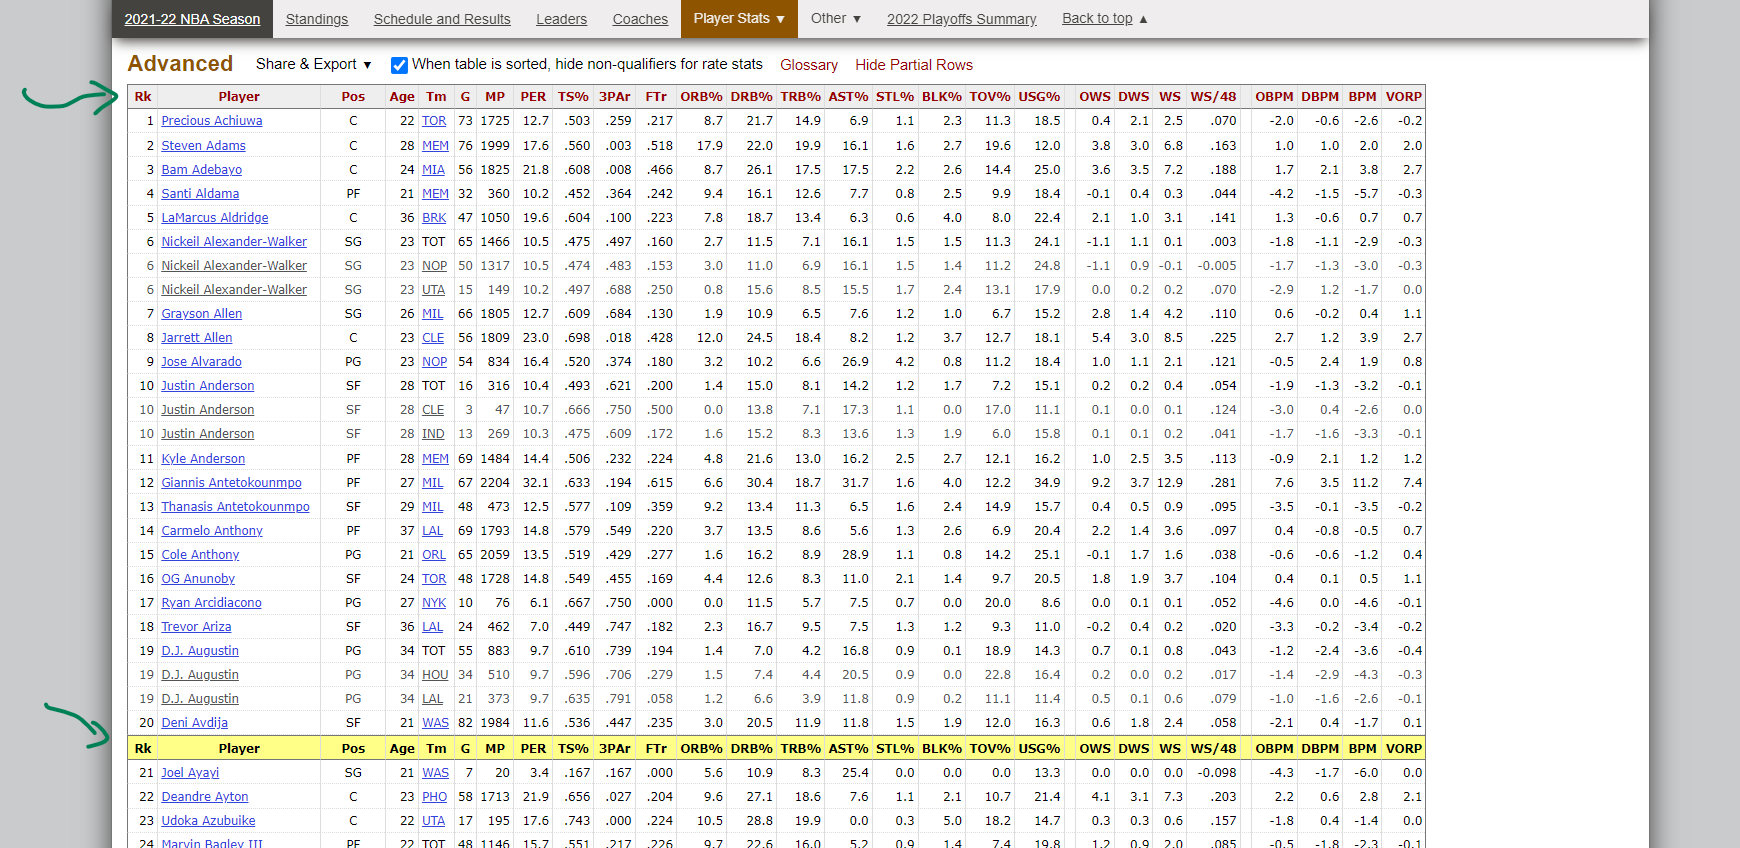

A tabela lida do endereço acima tem algumas linhas de títulos intercaladas com as linhas de dados propriamente ditos, como na imagem acima, por isso elas serão removidas:

In [ ]:
df_advanced = df_advanced[df_advanced['Rk'] != 'Rk']

In [ ]:
df_advanced.shape

(812, 29)

In [ ]:
df_advanced.reset_index(drop=True, inplace=True)

In [ ]:
df_advanced.tail()

Rk          Player Pos Age   Tm   G    MP   PER   TS%  3PAr  ...  \
807  601  Thaddeus Young  PF  33  TOR  26   475  15.8  .526  .299  ...   
808  602      Trae Young  PG  23  ATL  76  2652  25.4  .603  .395  ...   
809  603  Omer Yurtseven   C  23  MIA  56   706  17.4  .546  .045  ...   
810  604     Cody Zeller   C  29  POR  27   355  17.2  .627  .044  ...   
811  605     Ivica Zubac   C  24  LAC  76  1852  19.2  .660  .000  ...   

    Unnamed: 19  OWS  DWS    WS WS/48 Unnamed: 24  OBPM  DBPM   BPM  VORP  
807         NaN  0.5  0.8   1.3  .127         NaN  -0.2   2.2   2.0   0.5  
808         NaN  9.0  1.0  10.0  .181         NaN   7.1  -2.0   5.2   4.8  
809         NaN  0.8  1.4   2.1  .145         NaN  -1.4   0.4  -1.0   0.2  
810         NaN  0.9  0.2   1.1  .143         NaN  -1.2  -1.0  -2.1   0.0  
811         NaN  4.3  2.9   7.2  .187         NaN  -0.1   0.8   0.7   1.3  

[5 rows x 29 columns]

**Definindo os valores de colunas** inicializadas anteriormente com base nas colunas da tabela Advanced:

In [ ]:
df_new['ts_pct']=pd.to_numeric(df_advanced['TS%'])

In [ ]:
df_new['oreb_pct']=pd.to_numeric(df_advanced['ORB%'])/100
df_new['dreb_pct']=pd.to_numeric(df_advanced['DRB%'])/100
df_new['usg_pct']=pd.to_numeric(df_advanced['USG%'])/100
df_new['ast_pct']=pd.to_numeric(df_advanced['AST%'])/100

In [ ]:
df_new.head()

player_name team_abbreviation age  player_height  player_weight  \
0   Precious Achiuwa               TOR  22          203.0          102.0   
1       Steven Adams               MEM  28          211.0          120.0   
2        Bam Adebayo               MIA  24          206.0          115.0   
3       Santi Aldama               MEM  21          211.0          101.0   
4  LaMarcus Aldridge               BRK  36          211.0          113.0   

       college      country  draft_year  draft_round  draft_number  ...   pts  \
0      Memphis      Nigeria      2020.0          1.0          20.0  ...   9.1   
1         Pitt  New Zealand      2013.0          1.0          12.0  ...   6.9   
2     Kentucky          USA      2017.0          1.0          14.0  ...  19.1   
3  Loyola (MD)        Spain      2021.0          1.0          30.0  ...   4.1   
4        Texas          USA      2006.0          1.0           2.0  ...  12.9   

    reb  ast net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct   season  
0   6.5  1.1        0.0     0.087     0.217    0.185   0.503    0.069  2021-22  
1  10.0  3.4        4.2     0.179     0.220    0.120   0.560    0.161  2021-22  
2  10.1  3.4        5.5     0.087     0.261    0.250   0.608    0.175  2021-22  
3   2.7  0.7       -3.8     0.094     0.161    0.184   0.452    0.077  2021-22  
4   5.5  0.9        0.1     0.078     0.187    0.224   0.604    0.063  2021-22  

[5 rows x 21 columns]

In [ ]:
df_new.tail()

player_name team_abbreviation age  player_height  player_weight  \
807  Thaddeus Young               TOR  33          203.0          106.0   
808      Trae Young               ATL  23          185.0           74.0   
809  Omer Yurtseven               MIA  23          213.0          119.0   
810     Cody Zeller               POR  29          211.0          108.0   
811     Ivica Zubac               LAC  24          213.0          108.0   

          college                 country  draft_year  draft_round  \
807  Georgia Tech                     USA      2007.0          1.0   
808      Oklahoma                     USA      2018.0          1.0   
809      NC State                  Turkey         NaN          NaN   
810       Indiana                     USA      2013.0          1.0   
811                Bosnia and Herzegovina      2016.0          2.0   

     draft_number  ...   pts  reb  ast net_rating  oreb_pct  dreb_pct  \
807          12.0  ...   6.3  4.4  1.7        5.7     0.087     0.181   
808           5.0  ...  28.4  3.7  9.7       -1.2     0.021     0.096   
809           NaN  ...   5.3  5.3  0.9        NaN     0.139     0.330   
810           4.0  ...   5.2  4.6  0.8        1.5     0.149     0.241   
811          32.0  ...  10.3  8.5  1.6        0.5     0.128     0.237   

     usg_pct  ts_pct  ast_pct   season  
807    0.160   0.526    0.136  2021-22  
808    0.344   0.603    0.467  2021-22  
809    0.199   0.546    0.110  2021-22  
810    0.159   0.627    0.094  2021-22  
811    0.168   0.660    0.098  2021-22  

[5 rows x 21 columns]

###📅Play-by-play Table
Para obter:
  * net rating

In [ ]:
df_pbp = pd.read_html('https://www.basketball-reference.com/leagues/NBA_2022_play-by-play.html', header=1)[0]
df_pbp.head()

Rk             Player Pos Age   Tm   G    MP  PG%  SG%  SF%  ... On-Off  \
0  1   Precious Achiuwa   C  22  TOR  73  1725  NaN  NaN  NaN  ...    0.0   
1  2       Steven Adams   C  28  MEM  76  1999  NaN  NaN  NaN  ...    4.2   
2  3        Bam Adebayo   C  24  MIA  56  1825  NaN  NaN  NaN  ...    5.5   
3  4       Santi Aldama  PF  21  MEM  32   360  NaN  NaN   3%  ...   -3.8   
4  5  LaMarcus Aldridge   C  36  BRK  47  1050  NaN  NaN  NaN  ...    0.1   

  BadPass LostBall Shoot Off. Shoot.1 Off..1  PGA And1 Blkd  
0      19       26    70   24      64     10  200   15   51  
1      71       15    78   19      83     13  569   23   44  
2      59       39    72   38     173      8  480   48   40  
3       7        3    16    5      16      1   58    5    5  
4      12       11    46   12      56      0  110   22   11  

[5 rows x 23 columns]

In [ ]:
df_pbp.dtypes

Rk          object
Player      object
Pos         object
Age         object
Tm          object
G           object
MP          object
PG%         object
SG%         object
SF%         object
PF%         object
C%          object
OnCourt     object
On-Off      object
BadPass     object
LostBall    object
Shoot       object
Off.        object
Shoot.1     object
Off..1      object
PGA         object
And1        object
Blkd        object
dtype: object

In [ ]:
df_pbp.shape

(842, 23)

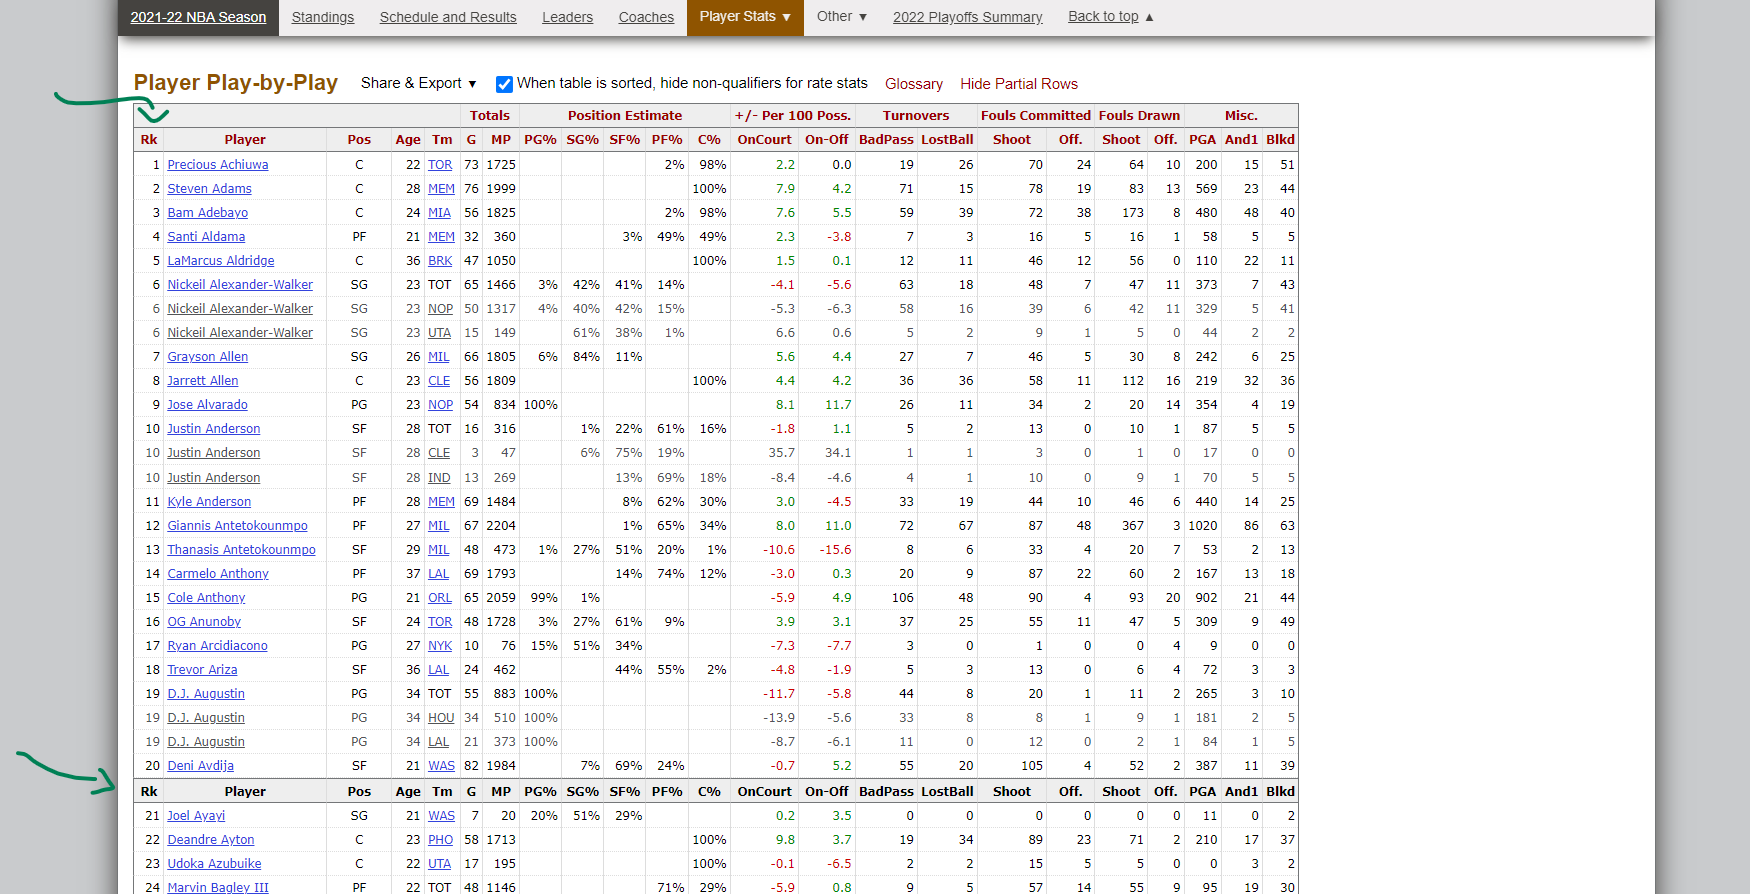

A tabela lida do endereço acima tem algumas linhas de títulos intercaladas com as linhas de dados propriamente ditos, como na imagem acima, por isso elas serão removidas:

In [ ]:
df_pbp=df_pbp[df_pbp['Rk'] != 'Rk']

In [ ]:
df_pbp.reset_index(drop=True, inplace=True)

In [ ]:
df_pbp.shape

(812, 23)

**Definindo os valores de colunas** inicializadas anteriormente com base nas colunas da tabela Play-by-play:

In [ ]:
df_new['net_rating']=pd.to_numeric(df_pbp['On-Off'])

In [ ]:
df_new.tail()

player_name team_abbreviation age  player_height  player_weight  \
807  Thaddeus Young               TOR  33          203.0          106.0   
808      Trae Young               ATL  23          185.0           74.0   
809  Omer Yurtseven               MIA  23          213.0          119.0   
810     Cody Zeller               POR  29          211.0          108.0   
811     Ivica Zubac               LAC  24          213.0          108.0   

          college                 country  draft_year  draft_round  \
807  Georgia Tech                     USA      2007.0          1.0   
808      Oklahoma                     USA      2018.0          1.0   
809      NC State                  Turkey         NaN          NaN   
810       Indiana                     USA      2013.0          1.0   
811                Bosnia and Herzegovina      2016.0          2.0   

     draft_number  ...   pts  reb  ast net_rating  oreb_pct  dreb_pct  \
807          12.0  ...   6.3  4.4  1.7        4.4     0.087     0.181   
808           5.0  ...  28.4  3.7  9.7        3.4     0.021     0.096   
809           NaN  ...   5.3  5.3  0.9        0.3     0.139     0.330   
810           4.0  ...   5.2  4.6  0.8        6.8     0.149     0.241   
811          32.0  ...  10.3  8.5  1.6       -6.8     0.128     0.237   

     usg_pct  ts_pct  ast_pct   season  
807    0.160   0.526    0.136  2021-22  
808    0.344   0.603    0.467  2021-22  
809    0.199   0.546    0.110  2021-22  
810    0.159   0.627    0.094  2021-22  
811    0.168   0.660    0.098  2021-22  

[5 rows x 21 columns]

###📅Dados gerais do jogador
Para obter:
* Peso e altura
* Faculdade
* País
* Informações do draft

Pegando os links para as páginas dos jogadores
- Identificar o elemento pai da tabela que contém uma coluna de jogadores
- Para cada linha obter o path da página individual dos jogadores

In [ ]:
url = 'https://www.basketball-reference.com/leagues/NBA_2022_per_game.html'
soup = BeautifulSoup(urlopen(url), 'html.parser')
info = soup.find(id="per_game_stats")
body = info.tbody
player_links = []
for row in body.find_all('tr'):
    if row.td:
      player_links.append(row.td.a.get('href'))

In [ ]:
len(player_links)

812

Para cada link extraindo os atributos de interesse dos jogadores (peso, altura, país de origem etc).

In [ ]:
def get_additional_player_info(row):
  def get_name_url(index: int):
    return f'https://www.basketball-reference.com{player_links[index]}'

  def has_numbers(input):
    return any(char.isdigit() for char in input)

  def get_height_and_weight(text):
    height, weight = np.nan, np.nan
    h = re.search(r'[0-9]+cm', text)
    if h:
      height = float(h.group(0).split('c')[0])
    w = re.search(r'[0-9]+kg', text)
    if w:
      weight = float(w.group(0).split('k')[0])
    return (height, weight)

  def get_country(a):
    country = ''
    c = re.search(r'country=[A-Z]+', a.__str__())
    if c:
      if c.group(0).split('=')[1] == 'US':
        country = 'USA'
      else:
        country = a.string
    return country

  def get_college(a):
    return a.string

  def get_draft_year(a):
    return int(a.string.split()[0])

  def get_draft_info(text):
    round, pick = np.nan, np.nan
    r = re.search(r"[0-9]+[(nd)|(st)|(rd)|(th)]+ round", text.__str__())
    if r:
      round = int(re.search(r'[0-9]+', r.group(0)).group(0))
    p = re.search(r"[0-9]+[(nd)|(st)|(rd)|(th)]+ overall", text.__str__())
    if p:
      pick = int(re.search(r'[0-9]+', p.group(0)).group(0))
    return round, pick

  url = get_name_url(row.name)
  soup = BeautifulSoup(urlopen(url), 'html.parser')
  info = soup.find(id="meta").contents[3] if soup.find("div", {"class": "media-item"}) else soup.find(id="meta").contents[1]
  
  for p in info.find_all('p'):
    if p.strong and p.strong.string:
      if 'Born' in p.strong.string:
        row['country']= get_country(p.find_all('span')[1].a)
      elif 'College' in p.strong.string:
        row['college'] = get_college(p.a)
      elif 'Draft' in p.strong.string:
        row['draft_year'] = get_draft_year(p.find_all('a')[1])
        row['draft_round'], row['draft_number'] = get_draft_info(p.contents[4])
    elif p.span and has_numbers(p.span.string) and not '(' in p.span.string:
      row['player_height'], row['player_weight'] = get_height_and_weight(p.contents[3])
    else:
      pass
  return row

In [ ]:
df_new.head()

player_name team_abbreviation age  player_height  player_weight  \
0   Precious Achiuwa               TOR  22            NaN            NaN   
1       Steven Adams               MEM  28            NaN            NaN   
2        Bam Adebayo               MIA  24            NaN            NaN   
3       Santi Aldama               MEM  21            NaN            NaN   
4  LaMarcus Aldridge               BRK  36            NaN            NaN   

  college country  draft_year  draft_round  draft_number  ...   pts   reb  \
0                         NaN          NaN           NaN  ...   9.1   6.5   
1                         NaN          NaN           NaN  ...   6.9  10.0   
2                         NaN          NaN           NaN  ...  19.1  10.1   
3                         NaN          NaN           NaN  ...   4.1   2.7   
4                         NaN          NaN           NaN  ...  12.9   5.5   

   ast net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct   season  
0  1.1        0.0     0.087     0.217    0.185   0.503    0.069  2021-22  
1  3.4        4.2     0.179     0.220    0.120   0.560    0.161  2021-22  
2  3.4        5.5     0.087     0.261    0.250   0.608    0.175  2021-22  
3  0.7       -3.8     0.094     0.161    0.184   0.452    0.077  2021-22  
4  0.9        0.1     0.078     0.187    0.224   0.604    0.063  2021-22  

[5 rows x 21 columns]

In [ ]:
df_new = df_new.apply(get_additional_player_info, axis=1)
df_new.tail()

In [ ]:
df_new.tail()

player_name team_abbreviation age  player_height  player_weight  \
807  Thaddeus Young               TOR  33          203.0          106.0   
808      Trae Young               ATL  23          185.0           74.0   
809  Omer Yurtseven               MIA  23          213.0          119.0   
810     Cody Zeller               POR  29          211.0          108.0   
811     Ivica Zubac               LAC  24          213.0          108.0   

          college                 country  draft_year  draft_round  \
807  Georgia Tech                     USA      2007.0          1.0   
808      Oklahoma                     USA      2018.0          1.0   
809      NC State                  Turkey         NaN          NaN   
810       Indiana                     USA      2013.0          1.0   
811                Bosnia and Herzegovina      2016.0          2.0   

     draft_number  ...   pts  reb  ast net_rating  oreb_pct  dreb_pct  \
807          12.0  ...   6.3  4.4  1.7        4.4     0.087     0.181   
808           5.0  ...  28.4  3.7  9.7        3.4     0.021     0.096   
809           NaN  ...   5.3  5.3  0.9        0.3     0.139     0.330   
810           4.0  ...   5.2  4.6  0.8        6.8     0.149     0.241   
811          32.0  ...  10.3  8.5  1.6       -6.8     0.128     0.237   

     usg_pct  ts_pct  ast_pct   season  
807    0.160   0.526    0.136  2021-22  
808    0.344   0.603    0.467  2021-22  
809    0.199   0.546    0.110  2021-22  
810    0.159   0.627    0.094  2021-22  
811    0.168   0.660    0.098  2021-22  

[5 rows x 21 columns]

##🏀Dataset final

Inserindo os dados no dataframe inicial e salvando em um novo arquivo csv

In [ ]:
df.shape

(11700, 21)

In [ ]:
df.tail()

player_name team_abbreviation   age  player_height  \
11695  Matthew Dellavedova               CLE  30.0         190.50   
11696     Maurice Harkless               SAC  28.0         200.66   
11697            Max Strus               MIA  25.0         195.58   
11698    Marcus Morris Sr.               LAC  31.0         203.20   
11699         Aaron Gordon               DEN  25.0         203.20   

       player_weight                          college    country draft_year  \
11695      90.718400  St.Mary's College of California  Australia  Undrafted   
11696      99.790240                       St. John's        USA       2012   
11697      97.522280                           DePaul        USA  Undrafted   
11698      98.883056                           Kansas        USA       2011   
11699     106.594120                          Arizona        USA       2014   

      draft_round draft_number  ...   pts  reb  ast  net_rating  oreb_pct  \
11695   Undrafted    Undrafted  ...   2.8  1.8  4.5        -3.1     0.029   
11696           1           15  ...   5.2  2.4  1.2        -2.9     0.017   
11697   Undrafted    Undrafted  ...   6.1  1.1  0.6        -4.2     0.011   
11698           1           14  ...  13.4  4.1  1.0         4.2     0.025   
11699           1            4  ...  12.4  5.7  3.2         2.1     0.055   

       dreb_pct  usg_pct  ts_pct  ast_pct   season  
11695     0.085    0.125   0.312    0.337  2020-21  
11696     0.097    0.114   0.527    0.071  2020-21  
11697     0.073    0.179   0.597    0.074  2020-21  
11698     0.133    0.194   0.614    0.056  2020-21  
11699     0.150    0.204   0.547    0.165  2020-21  

[5 rows x 21 columns]

In [ ]:
df = df.append(df_new, ignore_index=True)

In [ ]:
df.tail()

player_name team_abbreviation age  player_height  player_weight  \
12507  Thaddeus Young               TOR  33          203.0          106.0   
12508      Trae Young               ATL  23          185.0           74.0   
12509  Omer Yurtseven               MIA  23          213.0          119.0   
12510     Cody Zeller               POR  29          211.0          108.0   
12511     Ivica Zubac               LAC  24          213.0          108.0   

            college                 country draft_year draft_round  \
12507  Georgia Tech                     USA     2007.0         1.0   
12508      Oklahoma                     USA     2018.0         1.0   
12509      NC State                  Turkey        NaN         NaN   
12510       Indiana                     USA     2013.0         1.0   
12511                Bosnia and Herzegovina     2016.0         2.0   

      draft_number  ...   pts  reb  ast net_rating  oreb_pct  dreb_pct  \
12507         12.0  ...   6.3  4.4  1.7        4.4     0.087     0.181   
12508          5.0  ...  28.4  3.7  9.7        3.4     0.021     0.096   
12509          NaN  ...   5.3  5.3  0.9        0.3     0.139     0.330   
12510          4.0  ...   5.2  4.6  0.8        6.8     0.149     0.241   
12511         32.0  ...  10.3  8.5  1.6       -6.8     0.128     0.237   

       usg_pct  ts_pct  ast_pct   season  
12507    0.160   0.526    0.136  2021-22  
12508    0.344   0.603    0.467  2021-22  
12509    0.199   0.546    0.110  2021-22  
12510    0.159   0.627    0.094  2021-22  
12511    0.168   0.660    0.098  2021-22  

[5 rows x 21 columns]

In [ ]:
df.shape

(12512, 21)

In [ ]:
df.to_csv('/content/drive/MyDrive/2022.1/TA GDI/projeto1/data/all_seasons+2021-22.csv', index=False)

E de agora em diante, trabalharemos com o dataset aumentado: all_seasons+2021-22.csv

##🎲Carregar dataset final

In [4]:
# Path Amanda
data_path = '/content/drive/MyDrive/facul/2022.1/TAGDI/projeto1/data/all_seasons+2021-22.csv'

In [ ]:
# Path Tales
data_path = '/content/drive/MyDrive/2022.1/TA GDI/projeto1/data/all_seasons+2021-22.csv'

In [415]:
df = pd.read_csv(data_path)

In [ ]:
df.tail()

player_name team_abbreviation   age  player_height  player_weight  \
12507  Thaddeus Young               TOR  33.0          203.0          106.0   
12508      Trae Young               ATL  23.0          185.0           74.0   
12509  Omer Yurtseven               MIA  23.0          213.0          119.0   
12510     Cody Zeller               POR  29.0          211.0          108.0   
12511     Ivica Zubac               LAC  24.0          213.0          108.0   

            college                 country draft_year draft_round  \
12507  Georgia Tech                     USA     2007.0         1.0   
12508      Oklahoma                     USA     2018.0         1.0   
12509      NC State                  Turkey        NaN         NaN   
12510       Indiana                     USA     2013.0         1.0   
12511           NaN  Bosnia and Herzegovina     2016.0         2.0   

      draft_number  ...   pts  reb  ast  net_rating  oreb_pct  dreb_pct  \
12507         12.0  ...   6.3  4.4  1.7         4.4     0.087     0.181   
12508          5.0  ...  28.4  3.7  9.7         3.4     0.021     0.096   
12509          NaN  ...   5.3  5.3  0.9         0.3     0.139     0.330   
12510          4.0  ...   5.2  4.6  0.8         6.8     0.149     0.241   
12511         32.0  ...  10.3  8.5  1.6        -6.8     0.128     0.237   

       usg_pct  ts_pct  ast_pct   season  
12507    0.160   0.526    0.136  2021-22  
12508    0.344   0.603    0.467  2021-22  
12509    0.199   0.546    0.110  2021-22  
12510    0.159   0.627    0.094  2021-22  
12511    0.168   0.660    0.098  2021-22  

[5 rows x 21 columns]

##💻Pre-processamento

In [ ]:
df.shape

(12512, 21)

In [ ]:
df.head(15)

player_name team_abbreviation   age  player_height  player_weight  \
0      Travis Knight               LAL  22.0         213.36     106.594120   
1          Matt Fish               MIA  27.0         210.82     106.594120   
2       Matt Bullard               HOU  30.0         208.28     106.594120   
3       Marty Conlon               BOS  29.0         210.82     111.130040   
4    Martin Muursepp               DAL  22.0         205.74     106.594120   
5       Martin Lewis               TOR  22.0         198.12     102.058200   
6          Mark West               CLE  36.0         208.28     111.583632   
7    Mark Strickland               MIA  26.0         208.28      99.790240   
8         Mark Price               GSW  33.0         182.88      81.646560   
9       Mark Jackson               IND  32.0         190.50      83.914520   
10  Mark Hendrickson               PHI  23.0         205.74      99.790240   
11        Mark Davis               PHI  24.0         200.66      95.254320   
12       Mark Bryant               PHX  32.0         205.74     111.130040   
13      Mark Bradtke               PHI  28.0         208.28     120.201880   
14        Mario Elie               HOU  33.0         195.58      95.254320   

                            college country draft_year draft_round  \
0                       Connecticut     USA       1996           1   
1         North Carolina-Wilmington     USA       1992           2   
2                              Iowa     USA  Undrafted   Undrafted   
3                        Providence     USA  Undrafted   Undrafted   
4                              None     USA       1996           1   
5   Seward County Community College     USA       1995           2   
6                      Old Dominion     USA       1983           2   
7                            Temple     USA  Undrafted   Undrafted   
8                      Georgia Tech     USA       1986           2   
9                   St. John's (NY)     USA       1987           1   
10                 Washington State     USA       1996           2   
11                       Texas Tech     USA       1995           2   
12                       Seton Hall     USA       1988           1   
13                             None     USA  Undrafted   Undrafted   
14           American International     USA       1985           7   

   draft_number  ...   pts  reb   ast  net_rating  oreb_pct  dreb_pct  \
0            29  ...   4.8  4.5   0.5         6.2     0.127     0.182   
1            50  ...   0.3  0.8   0.0       -15.1     0.143     0.267   
2     Undrafted  ...   4.5  1.6   0.9         0.9     0.016     0.115   
3     Undrafted  ...   7.8  4.4   1.4        -9.0     0.083     0.152   
4            25  ...   3.7  1.6   0.5       -14.5     0.109     0.118   
5            50  ...   1.6  0.7   0.4        -3.5     0.087     0.045   
6            30  ...   3.2  2.7   0.3         3.5     0.092     0.146   
7     Undrafted  ...   2.0  1.2   0.0       -17.1     0.109     0.152   
8            25  ...  11.3  2.6   4.9        -3.1     0.023     0.088   
9            18  ...   9.9  4.8  11.4        -2.0     0.035     0.116   
10           31  ...   2.9  3.2   0.1        -5.1     0.113     0.201   
11           48  ...   8.5  4.3   1.8        -7.4     0.086     0.122   
12           21  ...   9.3  5.2   1.1         3.3     0.084     0.186   
13    Undrafted  ...   1.6  1.9   0.2         0.9     0.107     0.176   
14          160  ...  11.7  3.0   4.0         5.6     0.028     0.075   

    usg_pct  ts_pct  ast_pct   season  
0     0.142   0.536    0.052  1996-97  
1     0.265   0.333    0.000  1996-97  
2     0.151   0.535    0.099  1996-97  
3     0.167   0.542    0.101  1996-97  
4     0.233   0.482    0.114  1996-97  
5     0.135   0.470    0.125  1996-97  
6     0.137   0.555    0.034  1996-97  
7     0.232   0.448    0.013  1996-97  
8     0.192   0.597    0.289  1996-97  
9     0.155   0.525    0.464  1996-97  
10    0.133   0.481    0.014  

###🔢Definição de tipos

Alguns tipos das colunas do dataframe não estão de acordo com seus dados (o tipo `string` é mapeado para `object`).

- Draft year
  - Ano de recrutamento do jogador para ingressar na NBA, deveria ser numérico
- Draft round
  - Rodada do draft em que o jogador foi recrutado, deveria ser numérico
- Draft number
  - Número que identifica a posição de seleção do jogador dentre os 60 de cada draft, deveria ser numérico

Há também um caso especial de representação da informação:

- Season
  - A coluna season é representada como uma string no formato `<ano_de_inicio_da_temp>-<ano_final_da_temp>`, mas poderia ser representada por dois valores numéricos (ano de início e ano de fim da temporada).



In [416]:
df.dtypes

player_name           object
team_abbreviation     object
age                  float64
player_height        float64
player_weight        float64
college               object
country               object
draft_year            object
draft_round           object
draft_number          object
gp                     int64
pts                  float64
reb                  float64
ast                  float64
net_rating           float64
oreb_pct             float64
dreb_pct             float64
usg_pct              float64
ts_pct               float64
ast_pct              float64
season                object
dtype: object

In [417]:
df['player_name'] = df['player_name'].astype('category')
df['team_abbreviation'] = df['team_abbreviation'].astype('category')
df['college'] = df['college'].astype('category')
df['country'] = df['country'].astype('category')
df['season'] = df['season'].astype('category')

#### Colunas draft_year, draft_round e draft_number

Possuem dados faltantes (nan/null)

In [418]:
print(df.draft_year.isnull().any(), df.draft_round.isnull().any(), df.draft_number.isnull().any())

True True True


As 3 colunas são nulas conjuntamente

In [419]:
df[df.draft_year.isnull() & df.draft_round.isnull() & df.draft_number.isnull()].shape  # ocorrencias com valor nan em draft_year & round & number

(255, 21)

In [420]:
df[df.draft_year.isnull() | df.draft_round.isnull() | df.draft_number.isnull()].shape  # ocorrencias com valor nan em draft_year | round | number

(255, 21)

Além de valores numéricos ou nulos, há também a string 'Undrafted' em algumas amostras das 3 colunas.
Um jogador undrafted numa temporada é um jogador que não foi recrutado no draft, o que é uma informação relevante para a base. No entanto, essa informação pode ser transferida para uma outra coluna binária, permitindo que as demais tenham seus tipos melhor definidos.

In [421]:
print(df.draft_year.unique(), '\n\n', df.draft_round.unique(), '\n\n', df.draft_number.unique())

['1996' '1992' 'Undrafted' '1995' '1983' '1986' '1987' '1988' '1985'
 '1990' '1993' '1991' '1989' '1984' '1994' '1978' '1982' '1981' '1976'
 '1980' '1979' '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004'
 '2005' '2006' '2007' '2008' '2009' '2010' '2011' '1963' '2012' '2013'
 '2014' '2015' '2016' '2017' '2018' '2019' '2020' '2020.0' '2013.0'
 '2017.0' '2021.0' '2006.0' '2019.0' '2018.0' nan '2015.0' '2014.0'
 '2003.0' '2004.0' '2008.0' '2012.0' '2016.0' '2011.0' '2009.0' '2010.0'
 '2007.0' '2001.0' '2005.0'] 

 ['1' '2' 'Undrafted' '7' '3' '6' '4' '8' '0' '1.0' nan '2.0'] 

 ['29' '50' 'Undrafted' '25' '30' '18' '31' '48' '21' '160' '2' '46' '14'
 '44' '3' '28' '7' '13' '42' '52' '1' '9' '22' '8' '37' '11' '12' '33'
 '24' '5' '69' '35' '10' '38' '16' '6' '39' '32' '4' '19' '23' '36' '63'
 '20' '41' '26' '47' '15' '124' '43' '51' '40' '56' '17' '54' '139' '127'
 '27' '75' '165' '45' '57' '53' '34' '49' '79' '58' '66' '87' '120' '55'
 '82' '60' '59' '78' '0' '20.0' '12.0' '14.0' '3

O valore 'Undrafted' pode aparecer separadamente em uma das 3 colunas relacionadas ao draft (year, round, number).

In [422]:
df[(df.draft_year == 'Undrafted') & ((df.draft_round == 'Undrafted') & (df.draft_number == 'Undrafted'))].shape  # ocorrencias com valor Undrafted em draft_year & round & number

(2057, 21)

In [423]:
df[(df.draft_year == 'Undrafted') | ((df.draft_round == 'Undrafted') | (df.draft_number == 'Undrafted'))].shape  # ocorrencias com valor Undrafted em draft_year | round | number

(2096, 21)

Criação de nova coluna binária undrafted

In [424]:
def get_undrafted_value(draft_year, draft_round, draft_number):
  if draft_year == 'Undrafted' or draft_round == 'Undrafted' or draft_number == 'Undrafted': return 1 # represents undrafted players
  elif np.isnan(float(draft_year)) and np.isnan(float(draft_round)) and np.isnan(float(draft_number)): return np.nan # represents unavailable info
  else: return 0 # represents a drafted player

undrafted_column_values = df.apply(lambda x: get_undrafted_value(x['draft_year'], x['draft_round'], x['draft_number']), axis=1).to_numpy()
undrafted_column_values

array([ 0.,  0.,  1., ..., nan,  0.,  0.])

In [425]:
df['undrafted'] = undrafted_column_values

In [426]:
df['undrafted'].dtype # type float includes NaN

dtype('float64')

In [427]:
df.head()

player_name team_abbreviation   age  player_height  player_weight  \
0    Travis Knight               LAL  22.0         213.36      106.59412   
1        Matt Fish               MIA  27.0         210.82      106.59412   
2     Matt Bullard               HOU  30.0         208.28      106.59412   
3     Marty Conlon               BOS  29.0         210.82      111.13004   
4  Martin Muursepp               DAL  22.0         205.74      106.59412   

                     college country draft_year draft_round draft_number  ...  \
0                Connecticut     USA       1996           1           29  ...   
1  North Carolina-Wilmington     USA       1992           2           50  ...   
2                       Iowa     USA  Undrafted   Undrafted    Undrafted  ...   
3                 Providence     USA  Undrafted   Undrafted    Undrafted  ...   
4                       None     USA       1996           1           25  ...   

   reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  \
0  4.5  0.5         6.2     0.127     0.182    0.142   0.536    0.052   
1  0.8  0.0       -15.1     0.143     0.267    0.265   0.333    0.000   
2  1.6  0.9         0.9     0.016     0.115    0.151   0.535    0.099   
3  4.4  1.4        -9.0     0.083     0.152    0.167   0.542    0.101   
4  1.6  0.5       -14.5     0.109     0.118    0.233   0.482    0.114   

    season  undrafted  
0  1996-97        0.0  
1  1996-97        0.0  
2  1996-97        1.0  
3  1996-97        1.0  
4  1996-97        0.0  

[5 rows x 22 columns]

Removendo o valor 'Undrafted' das colunas draft_year, draft_round e draft_number e substituindo por NaN.

In [428]:
df.replace(to_replace='Undrafted', value=np.nan, inplace=True)
df.head()

player_name team_abbreviation   age  player_height  player_weight  \
0    Travis Knight               LAL  22.0         213.36      106.59412   
1        Matt Fish               MIA  27.0         210.82      106.59412   
2     Matt Bullard               HOU  30.0         208.28      106.59412   
3     Marty Conlon               BOS  29.0         210.82      111.13004   
4  Martin Muursepp               DAL  22.0         205.74      106.59412   

                     college country draft_year draft_round draft_number  ...  \
0                Connecticut     USA       1996           1           29  ...   
1  North Carolina-Wilmington     USA       1992           2           50  ...   
2                       Iowa     USA        NaN         NaN          NaN  ...   
3                 Providence     USA        NaN         NaN          NaN  ...   
4                       None     USA       1996           1           25  ...   

   reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  \
0  4.5  0.5         6.2     0.127     0.182    0.142   0.536    0.052   
1  0.8  0.0       -15.1     0.143     0.267    0.265   0.333    0.000   
2  1.6  0.9         0.9     0.016     0.115    0.151   0.535    0.099   
3  4.4  1.4        -9.0     0.083     0.152    0.167   0.542    0.101   
4  1.6  0.5       -14.5     0.109     0.118    0.233   0.482    0.114   

    season  undrafted  
0  1996-97        0.0  
1  1996-97        0.0  
2  1996-97        1.0  
3  1996-97        1.0  
4  1996-97        0.0  

[5 rows x 22 columns]

Redefinindo tipos das colunas

In [429]:
df = df.astype({"draft_year": float, "draft_round": float, "draft_number": float}) # usamos float ao inves de int porque o nan é tido como um float

In [430]:
df.dtypes

player_name          category
team_abbreviation    category
age                   float64
player_height         float64
player_weight         float64
college              category
country              category
draft_year            float64
draft_round           float64
draft_number          float64
gp                      int64
pts                   float64
reb                   float64
ast                   float64
net_rating            float64
oreb_pct              float64
dreb_pct              float64
usg_pct               float64
ts_pct                float64
ast_pct               float64
season               category
undrafted             float64
dtype: object

#### Coluna season

Verificando formato dos valores da coluna

In [431]:
df.season.unique()

['1996-97', '1997-98', '1998-99', '1999-00', '2000-01', ..., '2017-18', '2018-19', '2019-20', '2020-21', '2021-22']
Length: 26
Categories (26, object): ['1996-97', '1997-98', '1998-99', '1999-00', ..., '2018-19', '2019-20',
                          '2020-21', '2021-22']

Obtendo valores para novas colunas

In [432]:
def get_season_start_year(val):
  return int(val.split('-')[0])

def get_season_end_year(val):
  return get_season_start_year(val) + 1

season_start_year_values = df.season.apply(get_season_start_year).to_numpy()
season_end_year_values = df.season.apply(get_season_end_year).to_numpy()

Adicionando novas colunas season_start_year e season_end_year ao dataframe.

In [433]:
df['season_start_year'] = season_start_year_values
df['season_end_year'] = season_end_year_values

In [434]:
df.dtypes

player_name          category
team_abbreviation    category
age                   float64
player_height         float64
player_weight         float64
college              category
country              category
draft_year            float64
draft_round           float64
draft_number          float64
gp                      int64
pts                   float64
reb                   float64
ast                   float64
net_rating            float64
oreb_pct              float64
dreb_pct              float64
usg_pct               float64
ts_pct                float64
ast_pct               float64
season               category
undrafted             float64
season_start_year       int64
season_end_year         int64
dtype: object

In [435]:
df.head()

player_name team_abbreviation   age  player_height  player_weight  \
0    Travis Knight               LAL  22.0         213.36      106.59412   
1        Matt Fish               MIA  27.0         210.82      106.59412   
2     Matt Bullard               HOU  30.0         208.28      106.59412   
3     Marty Conlon               BOS  29.0         210.82      111.13004   
4  Martin Muursepp               DAL  22.0         205.74      106.59412   

                     college country  draft_year  draft_round  draft_number  \
0                Connecticut     USA      1996.0          1.0          29.0   
1  North Carolina-Wilmington     USA      1992.0          2.0          50.0   
2                       Iowa     USA         NaN          NaN           NaN   
3                 Providence     USA         NaN          NaN           NaN   
4                       None     USA      1996.0          1.0          25.0   

   ...  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct   season  \
0  ...         6.2     0.127     0.182    0.142   0.536    0.052  1996-97   
1  ...       -15.1     0.143     0.267    0.265   0.333    0.000  1996-97   
2  ...         0.9     0.016     0.115    0.151   0.535    0.099  1996-97   
3  ...        -9.0     0.083     0.152    0.167   0.542    0.101  1996-97   
4  ...       -14.5     0.109     0.118    0.233   0.482    0.114  1996-97   

   undrafted  season_start_year  season_end_year  
0        0.0               1996             1997  
1        0.0               1996             1997  
2        1.0               1996             1997  
3        1.0               1996             1997  
4        0.0               1996             1997  

[5 rows x 24 columns]

###❌Tratamento de dados ausentes

Atributos que contêm dados faltantes

- College
  - Universidade de origem do jogador
  - Um jogador pode não estar associado a uma universidade
  - Pode se tratar de uma informação faltante
- Draft year
  - Ano de recrutamento do jogador para ingressar na NBA
  - O jogador pode ser Undrafted (draf_year = nan)
  - Ou é uma informação faltante (draft_year = nan, undrafted = nan)
- Draft round
  - Rodada do draft em que o jogador foi recrutado
  - O jogador pode ser Undrafted (draf_round = nan)
  - Ou é uma informação faltante (draft_round = nan, undrafted = nan)
- Draft number
  - Número que identifica a posição de seleção do jogador dentre os 60 do draft
  - O jogador pode ser Undrafted (draf_number = nan)
  - Ou é uma informação faltante (draft_number = nan, undrafted = nan)
- Undrafted
  - Indica se o jogador não foi recrutado num draft até a temporada corrente
  - Valor 1 indica que é undrafted, valor 0 indica que não é undrafted (draft_year != nan)
  - Pode se tratar de uma informação faltante
- True shooting percentage (ts_pct)
  - ["No basquete, a porcentagem real de arremessos é uma estatística avançada que mede a eficiência de um jogador ao arremessar a bola"](https://https://en.wikipedia.org/wiki/True_shooting_percentage)
  - Pode se tratar de uma informação faltante

In [436]:
df.isnull().any()

player_name          False
team_abbreviation    False
age                  False
player_height        False
player_weight        False
college               True
country              False
draft_year            True
draft_round           True
draft_number          True
gp                   False
pts                  False
reb                  False
ast                  False
net_rating           False
oreb_pct             False
dreb_pct             False
usg_pct              False
ts_pct                True
ast_pct              False
season               False
undrafted             True
season_start_year    False
season_end_year      False
dtype: bool

In [437]:
df.describe()

age  player_height  player_weight    draft_year   draft_round  \
count  12512.000000   12512.000000   12512.000000  10200.000000  10163.000000   
mean      27.061861     200.585235     100.298150   2003.636765      1.304930   
std        4.330393       9.147448      12.467724      8.793283      0.506601   
min       18.000000     160.020000      60.327736   1963.000000      0.000000   
25%       24.000000     193.040000      90.718400   1997.000000      1.000000   
50%       26.000000     200.660000      99.790240   2004.000000      1.000000   
75%       30.000000     208.280000     108.862080   2011.000000      2.000000   
max       44.000000     231.140000     163.293120   2021.000000      8.000000   

       draft_number            gp           pts           reb           ast  \
count  10161.000000  12512.000000  12512.000000  12512.000000  12512.000000   
mean      21.891448     50.742887      8.146140      3.549816      1.810989   
std       16.077847     25.316104      5.968489      2.479556      1.795061   
min        0.000000      1.000000      0.000000      0.000000      0.000000   
25%        9.000000     30.000000      3.500000      1.800000      0.600000   
50%       19.000000     57.000000      6.700000      3.000000      1.200000   
75%       33.000000     73.000000     11.500000      4.700000      2.400000   
max      165.000000     85.000000     36.100000     16.300000     11.700000   

         net_rating      oreb_pct      dreb_pct      usg_pct        ts_pct  \
count  12512.000000  12512.000000  12512.000000  12512.00000  12499.000000   
mean      -2.318958      0.054919      0.141927      0.18504      0.511478   
std       12.964088      0.044557      0.063785      0.05367      0.101511   
min     -252.200000      0.000000      0.000000      0.00000      0.000000   
25%       -6.400000      0.021000      0.097000      0.14900      0.480000   
50%       -1.300000      0.041000      0.132000      0.18100      0.524000   
75%        3.200000      0.084000      0.181000      0.21700      0.561000   
max      300.000000      1.000000      1.000000      1.00000      1.500000   

            ast_pct     undrafted  season_start_year  season_end_year  
count  12512.000000  12257.000000       12512.000000     12512.000000  
mean       0.131063      0.171004        2009.264146      2010.264146  
std        0.094488      0.376528           7.691082         7.691082  
min        0.000000      0.000000        1996.000000      1997.000000  
25%        0.065000      0.000000        2003.000000      2004.000000  
50%        0.103000      0.000000        2010.000000      2011.000000  
75%        0.178000      0.000000        2016.000000      2017.000000  
max        1.000000      1.000000        2021.000000      2022.000000

#### Tratando colunas relacionadas ao draft

In [438]:
len(df[df['undrafted'].isnull()])

255

In [439]:
len(df[df['undrafted'].isnull() & df['draft_year'].isnull() & df['draft_round'].isnull() & df['draft_number'].isnull()])

255

In [440]:
df[df['undrafted'].isnull() & df['draft_year'].isnull() & df['draft_round'].isnull() & df['draft_number'].isnull()]

player_name team_abbreviation   age  player_height  player_weight  \
11710     Jose Alvarado               NOP  23.0          183.0           81.0   
11720  Ryan Arcidiacono               NYK  27.0          190.0           88.0   
11726        Joel Ayayi               WAS  21.0          196.0           81.0   
11737        Cat Barber               ATL  27.0          188.0           86.0   
11742        Paris Bass               PHO  26.0          203.0           90.0   
...                 ...               ...   ...            ...            ...   
12501      Moses Wright               TOT  23.0          206.0          105.0   
12502      Moses Wright               LAC  23.0          206.0          105.0   
12503      Moses Wright               DAL  23.0          206.0          105.0   
12504         Gabe York               IND  28.0          190.0           83.0   
12509    Omer Yurtseven               MIA  23.0          213.0          119.0   

             college country  draft_year  draft_round  draft_number  ...  \
11710   Georgia Tech     USA         NaN          NaN           NaN  ...   
11720      Villanova     USA         NaN          NaN           NaN  ...   
11726        Gonzaga  France         NaN          NaN           NaN  ...   
11737       NC State     USA         NaN          NaN           NaN  ...   
11742  Detroit Mercy     USA         NaN          NaN           NaN  ...   
...              ...     ...         ...          ...           ...  ...   
12501   Georgia Tech     USA         NaN          NaN           NaN  ...   
12502   Georgia Tech     USA         NaN          NaN           NaN  ...   
12503   Georgia Tech     USA         NaN          NaN           NaN  ...   
12504        Arizona     USA         NaN          NaN           NaN  ...   
12509       NC State  Turkey         NaN          NaN           NaN  ...   

       net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct   season  \
11710        11.7     0.032     0.102    0.184   0.520    0.269  2021-22   
11720        -7.7     0.000     0.115    0.086   0.667    0.075  2021-22   
11726         3.5     0.056     0.109    0.133   0.167    0.254  2021-22   
11737        34.0     0.085     0.167    0.227   0.000    0.267  2021-22   
11742         4.8     0.315     0.299    0.546   0.436    0.000  2021-22   
...           ...       ...       ...      ...     ...      ...      ...   
12501       -25.1     0.079     0.159    0.171   0.470    0.168  2021-22   
12502        16.5     0.000     0.000    0.000     NaN    1.000  2021-22   
12503       -28.3     0.085     0.171    0.184   0.470    0.104  2021-22   
12504        -6.7     0.000     0.108    0.208   0.435    0.251  2021-22   
12509         0.3     0.139     0.330    0.199   0.546    0.110  2021-22   

       undrafted  season_start_year  season_end_year  
11710        NaN               2021             2022  
11720        NaN               2021             2022  
11726        NaN               2021             2022  
11737        NaN               2021             2022  
11742        NaN               2021             2022  
...          ...                ...              ...  
12501        NaN               2021             2022  
12502        NaN               2021             2022  
12503        NaN               2021             2022  
12504        NaN               2021             2022  
12509        NaN               2021             2022  

[255 rows x 24 columns]

Ou seja, nota-se que todas as ocorrências de valores faltantes na coluna undrafted se tratam de valores faltantes também nas colunas relacionadas ao draft. Além disso, como todas as ocorrências estão no range de valores preenchidos utilizando o BasketballReference, concluímos que trata-se de jogares não draftados de fato.

In [441]:
df.loc[df['undrafted'].isnull(), ['undrafted']] = 1

In [442]:
df['undrafted'].isnull().any()

False

Agora tratando as colunas draft round, year e number separadamente

In [443]:
df['draft_number'].isnull().sum(), df['draft_round'].isnull().sum(), df['draft_year'].isnull().sum()

(2351, 2349, 2312)

Entendendo se há valores nulos nas colunas de draft quando a coluna undrafted é igual a 0:

In [444]:
df[(df['draft_year'].isnull() | df['draft_round'].isnull() | df['draft_year'].isnull()) & (df['undrafted'] == 0.0)]

Empty DataFrame
Columns: [player_name, team_abbreviation, age, player_height, player_weight, college, country, draft_year, draft_round, draft_number, gp, pts, reb, ast, net_rating, oreb_pct, dreb_pct, usg_pct, ts_pct, ast_pct, season, undrafted, season_start_year, season_end_year]
Index: []

[0 rows x 24 columns]

Como não há valores nulos em `draft_year`, `draft_round` e `draft_number` quando `undrafted=0`, então todos os dados faltantes nas 3 colunas estão representados pela coluna undrafted e as colunas e não precisam de tratamento.

Entendendo se há valores não nulos nas colunas de draft quando a coluna undrafted é igual a 1:

In [445]:
df[(df['draft_year'].notnull() | df['draft_round'].notnull() | df['draft_year'].notnull()) & (df['undrafted'] == 1.0)]

player_name team_abbreviation   age  player_height  \
376        Ivano Newbill               ATL  26.0         208.28   
402           Devin Gray               SAS  25.0         200.66   
438    Eldridge Recasner               ATL  29.0         193.04   
454    Eldridge Recasner               ATL  30.0         193.04   
501        Ivano Newbill               VAN  27.0         208.28   
714        Reggie Hanson               BOS  29.0         203.20   
984    Eldridge Recasner               CHH  31.0         193.04   
1111     Randell Jackson               WAS  23.0         210.82   
1504     Randell Jackson               DAL  24.0         210.82   
1557          Devin Gray               HOU  28.0         200.66   
1606   Eldridge Recasner               CHH  32.0         193.04   
1883      Jamal Robinson               MIA  27.0         200.66   
2175   Eldridge Recasner               CHH  33.0         193.04   
2592   Eldridge Recasner               LAC  34.0         190.50   
3011          Guy Rucker               GSW  25.0         205.74   
6981        Xavier Silas               PHI  24.0         195.58   
9887        Xavier Silas               BOS  30.0         195.58   
10674      Dusty Hannahs               MEM  26.0         190.50   
10688          Eric Mika               SAC  25.0         208.28   
10711        Joe Chealey               CHA  24.0         193.04   
10731        J.P. Macura               CLE  25.0         193.04   
10809      Allonzo Trier               NYK  24.0         193.04   
10810    Amile Jefferson               ORL  27.0         205.74   
10831        Daryl Macon               MIA  24.0         187.96   
10863     Chasson Randle               GSW  27.0         187.96   
10926     T.J. McConnell               IND  28.0         185.42   
10987   Zach Norvell Jr.               GSW  22.0         195.58   
11076    Justin Robinson               WAS  22.0         185.42   
11137       Malik Newman               CLE  23.0         190.50   
11155     Marques Bolden               CLE  22.0         208.28   
11297      Devin Cannady               ORL  25.0         187.96   
11360      Armoni Brooks               HOU  23.0         190.50   
11405     Chasson Randle               ORL  28.0         187.96   
11425     Dakota Mathias               PHI  25.0         193.04   
11437      Robert Franks               ORL  24.0         200.66   
11540     T.J. McConnell               IND  29.0         185.42   
11619    Justin Robinson               OKC  23.0         185.42   
11630     Keljin Blevins               POR  25.0         193.04   
11688     Marques Bolden               CLE  23.0         208.28   

       player_weight                college country  draft_year  draft_round  \
376       111.130040           Georgia Tech     USA      1994.0          NaN   
402       108.862080                Clemson     USA      1995.0          NaN   
438        86.182480             Washington     USA      1992.0          NaN   
454        86.182480             Washington     USA      1992.0          NaN   
501       111.130040           Georgia Tech     USA      1994.0          NaN   
714        88.450440               Kentucky     USA      1998.0          NaN   
984        86.182480             Washington     USA      1992.0          NaN   
1111       97.522280          Florida State     USA      1999.0          NaN   
1504       97.522280          Florida State     USA      1999.0          NaN   
1557      108.862080                Clemson     USA      1995.0          NaN   
1606       86.182480             Washington     USA      1992.0          NaN   
1883       96.161504               Virginia     USA      1997.0          NaN   
2175       87.089664             Washington     USA      1992.0          NaN   
2592       86.182480             Washington     USA      1992.0          NaN   
3011      122.469840                   Iowa     USA      1999.0          NaN   
6981       92.986360      Northern Illinois     USA 

Há 39 ocorrências onde os jogadores estão descritos como undrafted (`undrafted=1`) e as colunas `draft_year` e/ou `draft_round` não são nulas. 

Como todas essas ocorrências já são sobre jogadores undrafted - confirmação obtida também por pesquisa - e os demais undrafted não possuem a informação do draft_year, esses valores não nulos serão substituídos por NaN.

In [446]:
df.loc[df['draft_year'].notnull() & (df['undrafted'] == 1.0), 'draft_year'] = np.nan
df.loc[df['draft_round'].notnull() & (df['undrafted'] == 1.0), 'draft_round'] = np.nan

In [447]:
df[(df['draft_year'].notnull() | df['draft_round'].notnull() | df['draft_year'].notnull()) & (df['undrafted'] == 1.0)]

Empty DataFrame
Columns: [player_name, team_abbreviation, age, player_height, player_weight, college, country, draft_year, draft_round, draft_number, gp, pts, reb, ast, net_rating, oreb_pct, dreb_pct, usg_pct, ts_pct, ast_pct, season, undrafted, season_start_year, season_end_year]
Index: []

[0 rows x 24 columns]

Agora todas as 3 colunas relacionadas a draft estão nulas conjuntamente quando o jogador é undrafted.

In [448]:
df['draft_number'].isnull().sum(), df['draft_round'].isnull().sum(), df['draft_year'].isnull().sum()

(2351, 2351, 2351)

#### Tratando a coluna TrueShooting%

In [449]:
df['ts_pct'].isnull().sum()

13

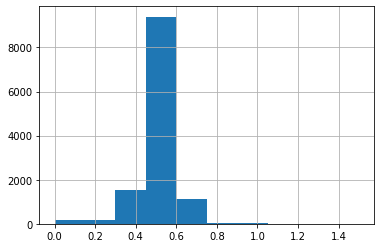

In [450]:
df['ts_pct'].hist()

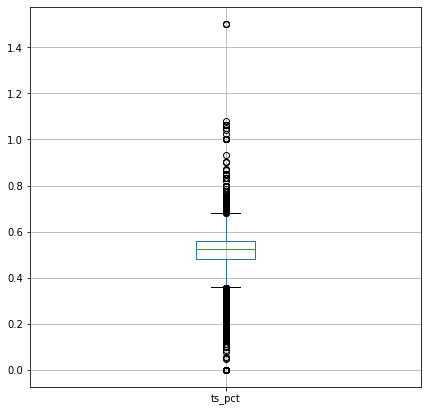

In [451]:
df.boxplot('ts_pct', figsize=(7,7))

In [452]:
df[df['ts_pct'].isnull()]

player_name team_abbreviation   age  player_height  \
11750          Jordan Bell               CHI  27.0          203.0   
11823  Willie Cauley-Stein               PHI  28.0          213.0   
11865           Sam Dekker               TOR  27.0          206.0   
11866      Javin DeLaurier               MIL  23.0          208.0   
11899      Jaime Echenique               WAS  24.0          211.0   
11938       Wenyen Gabriel               BRK  24.0          206.0   
11979           Tyler Hall               NYK  24.0          196.0   
12069        DeJon Jarreau               IND  24.0          196.0   
12208           C.J. Miles               BOS  34.0          198.0   
12229         Juwan Morgan               BOS  24.0          201.0   
12238           Ade Murkey               SAC  24.0          196.0   
12369          Chris Silva               MIN  25.0          203.0   
12502         Moses Wright               LAC  23.0          206.0   

       player_weight            college   country  draft_year  draft_round  \
11750           97.0             Oregon       USA      2017.0          2.0   
11823          108.0           Kentucky       USA      2015.0          1.0   
11865          104.0          Wisconsin       USA      2015.0          1.0   
11866          107.0               Duke       USA         NaN          NaN   
11899          117.0  Trinity Valley CC  Colombia         NaN          NaN   
11938           92.0           Kentucky     Sudan         NaN          NaN   
11979           94.0      Montana State       USA         NaN          NaN   
12069           83.0              UMass       USA         NaN          NaN   
12208           99.0                NaN       USA      2005.0          2.0   
12229          105.0            Indiana       USA         NaN          NaN   
12238           90.0             Denver       USA         NaN          NaN   
12369          106.0     South Carolina     Gabon         NaN          NaN   
12502          105.0       Georgia Tech       USA         NaN          NaN   

       draft_number  ...  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  \
11750          38.0  ...        25.3     0.566     0.000      0.0     NaN   
11823           6.0  ...        30.7     0.000     0.366      0.0     NaN   
11865          18.0  ...      -252.2     0.000     0.000      0.0     NaN   
11866           NaN  ...        82.6     0.000     0.346      0.0     NaN   
11899           NaN  ...       -21.7     0.000     0.000      0.0     NaN   
11938           NaN  ...        98.7     0.000     1.000      0.0     NaN   
11979           NaN  ...       -90.3     0.000     0.000      0.0     NaN   
12069           NaN  ...         4.1     0.000     0.000      0.0     NaN   
12208          34.0  ...      -132.8     0.000     0.000      0.0     NaN   
12229           NaN  ...        90.0     0.000     0.000      0.0     NaN   
12238           NaN  ...       -11.2     0.000     0.000      0.0     NaN   
12369           NaN  ...       -77.5     0.000     0.366      0.0     NaN   
12502           NaN  ...        16.5     0.000     0.000      0.0     NaN   

       ast_pct   season  undrafted  season_start_year  season_end_year  
11750    0.000  2021-22        0.0               2021             2022  
11823    0.204  2021-22        0.0               2021             2022  
11865    0.000  2021-22        0.0               2021             2022  
11866    0.000  2021-22        1.0               2021             2022  
11899    0.000  2021-22        1.0               2021             2022  
11938    0.000  2021-22        1.0               2021             2022  
11979    0.000  2021-22        1.0               2021             2022  
12069    0.000  2021-22        1.0               2021             2022  
12208    0.000  2021-22        0.0               2021             2022  
12229    0.000  2021-22        1.0               2021             2022  
12238    0.000  2021-22        1.0               2021             2022  


Devido à simetria da variável em análise (vide histograma acima), vamos utilizar a estratégia de preencher seus valores faltantes com a mediana.

In [453]:
ts_median = df['ts_pct'].median()
ts_median

0.524

In [454]:
df['ts_pct'] = df['ts_pct'].fillna(ts_median)

In [455]:
df['ts_pct'].isna().sum()

0

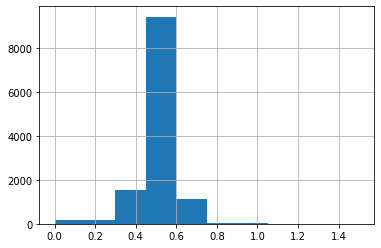

In [456]:
df['ts_pct'].hist()

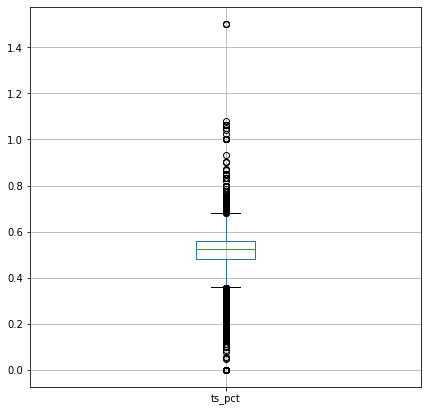

In [457]:
df.boxplot('ts_pct', figsize=(7,7))

#### Tratando coluna 'College'

In [458]:
df['college'].isna().sum()

95

In [459]:
df['college'].value_counts()

None                1715
Kentucky             431
Duke                 393
North Carolina       332
UCLA                 313
                    ... 
UMass                  1
Lewis (IL)             1
Lincoln Memorial       1
UC Santa Barbara       1
UNC Wilmington         1
Name: college, Length: 382, dtype: int64

Como sabemos que tipicamente a universidade de jogadores estrangeiros não é informada (caso seja fora dos EUA) preencheremos estes com 'None' e vamos analisar apenas os jogadores americanos

In [460]:
df[df['college'].isna() & (df['country'] == 'USA')]

player_name team_abbreviation   age  player_height  \
11732         LaMelo Ball               CHO  20.0          201.0   
11747       Darius Bazley               OKC  21.0          203.0   
11967         Jalen Green               HOU  19.0          193.0   
11980        R.J. Hampton               ORL  20.0          193.0   
11997  Isaiah Hartenstein               LAC  23.0          213.0   
12001       Killian Hayes               DET  20.0          196.0   
12039       Dwight Howard               LAL  36.0          208.0   
12068        LeBron James               LAL  37.0          206.0   
12180   Kenyon Martin Jr.               HOU  21.0          198.0   
12208          C.J. Miles               BOS  34.0          198.0   
12252         Daishen Nix               HOU  19.0          196.0   
12372     Anfernee Simons               POR  22.0          190.0   
12433         Isaiah Todd               WAS  20.0          208.0   
12487        Lou Williams               ATL  35.0          185.0   

       player_weight college country  draft_year  draft_round  draft_number  \
11732           81.0     NaN     USA      2020.0          1.0           3.0   
11747           94.0     NaN     USA      2019.0          1.0          23.0   
11967           80.0     NaN     USA      2021.0          1.0           2.0   
11980           79.0     NaN     USA      2020.0          1.0          24.0   
11997          113.0     NaN     USA      2017.0          2.0          43.0   
12001           88.0     NaN     USA      2020.0          1.0           7.0   
12039          120.0     NaN     USA      2004.0          1.0           1.0   
12068          113.0     NaN     USA      2003.0          1.0           1.0   
12180           97.0     NaN     USA      2020.0          2.0          52.0   
12208           99.0     NaN     USA      2005.0          2.0          34.0   
12252          101.0     NaN     USA         NaN          NaN           NaN   
12372           82.0     NaN     USA      2018.0          1.0          24.0   
12433           99.0     NaN     USA      2021.0          2.0          31.0   
12487           79.0     NaN     USA      2005.0          2.0          45.0   

       ...  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct   season  \
11732  ...         1.7     0.047     0.174    0.282   0.554    0.357  2021-22   
11747  ...        -6.4     0.037     0.198    0.183   0.515    0.077  2021-22   
11967  ...        -6.7     0.017     0.100    0.237   0.547    0.131  2021-22   
11980  ...        -9.5     0.017     0.129    0.184   0.481    0.169  2021-22   
11997  ...         9.9     0.105     0.182    0.184   0.664    0.205  2021-22   
12001  ...        -4.2     0.022     0.120    0.157   0.461    0.246  2021-22   
12039  ...        -4.1     0.131     0.263    0.146   0.657    0.050  2021-22   
12068  ...         2.1     0.033     0.204    0.323   0.619    0.306  2021-22   
12180  ...         2.7     0.053     0.145    0.163   0.603    0.094  2021-22   
12208  ...      -132.8     0.000     0.000    0.000   0.524    0.000  2021-22   
12252  ...         1.2     0.029     0.110    0.173   0.480    0.215  2021-22   
12372  ...        11.4     0.016     0.085    0.248   0.583    0.222  2021-22   
12433  ...       -17.0     0.046     0.133    0.196   0.349    0.073  2021-22   
12487  ...        -1.6     0.022     0.097    0.217   0.500    0.186  2021-22   

       undrafted  season_start_year  season_end_year  
11732        0.0               2021             2022  
11747        0.0               2021             2022  
11967        0.0               2021             2022  
11980        0.0               2021             2022  
11997        0.0               2021             2022  
12001        0.0               2021             2022  
12039        0.0               2021             2022  
12068        0.0               2021             2022  
12180        0.0               2021             2022  
12208        0.0               2021      

Após as pesquisas, concluímos que estes também não foram pro college tradicionalmente

In [461]:
col_mode = df['college'].mode()[0]
col_mode

'None'

In [462]:
df['college'] = df['college'].fillna(col_mode)

In [463]:
df['college'].isna().sum()

0

In [464]:
df.isnull().any()

player_name          False
team_abbreviation    False
age                  False
player_height        False
player_weight        False
college              False
country              False
draft_year            True
draft_round           True
draft_number          True
gp                   False
pts                  False
reb                  False
ast                  False
net_rating           False
oreb_pct             False
dreb_pct             False
usg_pct              False
ts_pct               False
ast_pct              False
season               False
undrafted            False
season_start_year    False
season_end_year      False
dtype: bool

###🧼Limpeza de dados/remoção de outliers

Vamos agora analisar atributos que caracterizam métricas sobre os jogadores:
```
'pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'gp_pct'
```



#### Games played pct (gp_pct) (bivariado)

Houve anos em que as seasons tiveram menos jogos que o típico (82):
- season 2020-2021
  - 72 jogos
- season 2019-2020
  - 72 jogos
- season 2011-2012
  - 66 jogos
- season 1998-1999
  - 50 jogos

Devido a isso, alguns jogadores podem ter suas métricas muito acima ou muito abaixo do range mais comum porque jogaram poucas vezes. Por isso, uma nova coluna será calculada para cada linha de acordo com:

```markdown
games played / total games of the season
```

In [465]:
df.head()

player_name team_abbreviation   age  player_height  player_weight  \
0    Travis Knight               LAL  22.0         213.36      106.59412   
1        Matt Fish               MIA  27.0         210.82      106.59412   
2     Matt Bullard               HOU  30.0         208.28      106.59412   
3     Marty Conlon               BOS  29.0         210.82      111.13004   
4  Martin Muursepp               DAL  22.0         205.74      106.59412   

                     college country  draft_year  draft_round  draft_number  \
0                Connecticut     USA      1996.0          1.0          29.0   
1  North Carolina-Wilmington     USA      1992.0          2.0          50.0   
2                       Iowa     USA         NaN          NaN           NaN   
3                 Providence     USA         NaN          NaN           NaN   
4                       None     USA      1996.0          1.0          25.0   

   ...  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct   season  \
0  ...         6.2     0.127     0.182    0.142   0.536    0.052  1996-97   
1  ...       -15.1     0.143     0.267    0.265   0.333    0.000  1996-97   
2  ...         0.9     0.016     0.115    0.151   0.535    0.099  1996-97   
3  ...        -9.0     0.083     0.152    0.167   0.542    0.101  1996-97   
4  ...       -14.5     0.109     0.118    0.233   0.482    0.114  1996-97   

   undrafted  season_start_year  season_end_year  
0        0.0               1996             1997  
1        0.0               1996             1997  
2        1.0               1996             1997  
3        1.0               1996             1997  
4        0.0               1996             1997  

[5 rows x 24 columns]

In [466]:
seasons_games = {'1998-99': 50, '2011-12': 66, '2019-20': 72, '2020-21': 72}

In [467]:
gp_pct_values = df.apply(lambda val: val.gp / seasons_games[val.season] if val.season in seasons_games else val.gp / 82, axis=1)
gp_pct_values

0        0.865854
1        0.073171
2        0.865854
3        0.902439
4        0.512195
           ...   
12507    0.317073
12508    0.926829
12509    0.682927
12510    0.329268
12511    0.926829
Length: 12512, dtype: float64

In [468]:
df['gp_pct'] = gp_pct_values

Vamos agora verificar os outliers dos nossos dados com relação ao novo atributo `gp_pct`

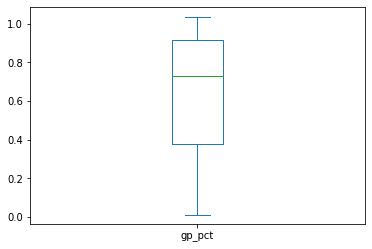

In [469]:
df['gp_pct'].plot.box()

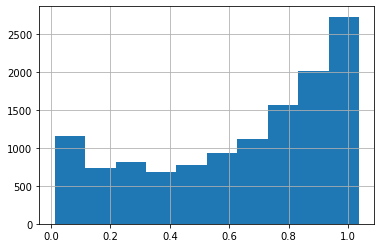

In [470]:
df['gp_pct'].hist()

Não foram identificados outliers.

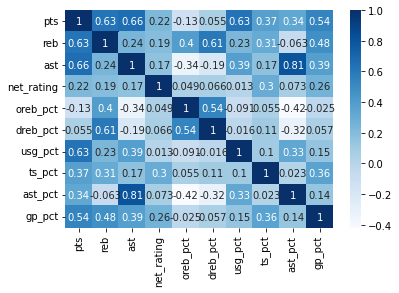

In [471]:
# calculate the correlation matrix
corr = df[['pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'gp_pct']].corr()

# plot the heatmap
sns.heatmap(corr, cmap="Blues", annot=True)

#### True shooting (ts_pct)

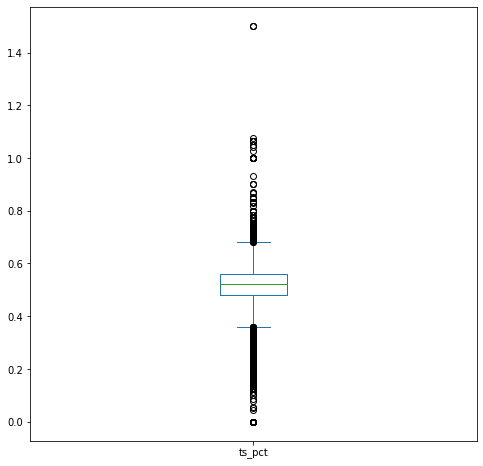

In [472]:
df['ts_pct'].plot.box(figsize=(8,8))

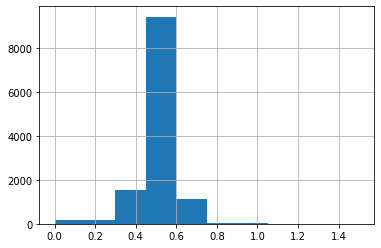

In [473]:
df['ts_pct'].hist()

Observamos que há uma distribuição simétrica de ts_pct, mas foi detectada a presença de outliers pelo boxplot (valores mais distantes do máximo e mínimo da caixa). Para tratá-los, vamos utilizar o z-score.

In [474]:
ts_pct_mean = df['ts_pct'].mean() # media do atributo
ts_pct_sd = df['ts_pct'].std() # desvio padrao do atributo

In [475]:
ts_pct_outliers = df[(abs(df['ts_pct'] - ts_pct_mean) / ts_pct_sd) > 3.5] # obtendo os outliers a partir do z-score das amostras
ts_pct_outliers

player_name team_abbreviation   age  player_height  player_weight  \
265     Cuonzo Martin               MIL  25.0         195.58      96.615096   
275       Bruce Bowen               MIA  26.0         200.66      90.718400   
281    Anthony Miller               ATL  25.0         205.74     115.665960   
371       James Scott               MIA  25.0         198.12      81.646560   
406    Derrick Alston               ATL  24.0         210.82     102.058200   
...               ...               ...   ...            ...            ...   
12412    Tyrell Terry               MEM  21.0         188.00      72.000000   
12413       Jon Teske               MEM  24.0         216.00     120.000000   
12439   Rayjon Tucker               TOT  24.0         190.00      94.000000   
12441   Rayjon Tucker               MIL  24.0         190.00      94.000000   
12458     M.J. Walker               PHO  23.0         196.00      96.000000   

                   college country  draft_year  draft_round  draft_number  \
265                 Purdue     USA      1995.0          2.0          57.0   
275    Cal State-Fullerton     USA         NaN          NaN           NaN   
281         Michigan State     USA      1994.0          2.0          39.0   
371        St. John's (NY)     USA         NaN          NaN           NaN   
406               Duquesne     USA      1994.0          2.0          33.0   
...                    ...     ...         ...          ...           ...   
12412             Stanford     USA      2020.0          2.0          31.0   
12413             Michigan     USA         NaN          NaN           NaN   
12439   Florida Gulf Coast     USA         NaN          NaN           NaN   
12441   Florida Gulf Coast     USA         NaN          NaN           NaN   
12458        Florida State     USA         NaN          NaN           NaN   

       ...  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct   season  undrafted  \
265    ...     0.048     0.000    0.214   0.000    0.100  1996-97        0.0   
275    ...     0.000     0.000    0.000   0.000    0.000  1996-97        1.0   
281    ...     0.111     0.714    0.149   0.000    0.000  1996-97        0.0   
371    ...     0.036     0.147    0.158   0.056    0.136  1996-97        1.0   
406    ...     0.188     0.200    0.213   0.000    0.000  1996-97        0.0   
...    ...       ...       ...      ...     ...      ...      ...        ...   
12412  ...     0.000     0.000    0.137   1.000    0.000  2021-22        0.0   
12413  ...     0.000     0.268    0.096   0.000    0.138  2021-22        1.0   
12439  ...     0.047     0.075    0.079   0.869    0.181  2021-22        1.0   
12441  ...     0.052     0.049    0.095   0.901    0.191  2021-22        1.0   
12458  ...     0.000     0.131    0.215   0.000    0.138  2021-22        1.0   

       season_start_year  season_end_year    gp_pct  
265                 1996             1997  0.036585  
275                 1996             1997  0.012195  
281                 1996             1997  0.012195  
371                 1996             1997  0.097561  
406                 1996             1997  0.024390  
...                  ...              ...       ...  
12412               2021             2022  0.024390  
12413               2021             2022  0.036585  
12439               2021             2022  0.060976  
12441               2021             2022  0.024390  
12458               2021             2022  0.024390  

[236 rows x 25 columns]

Cerca de 230 amostras são outliers com relação ao ts_pct (possuem valores muito baixos ou muito acima do esperado). Por se tratar de um pequeno subconjunto dos nossos dados, essas ocorrências serão removidas.

In [476]:
df = df[(abs(df['ts_pct'] - ts_pct_mean) / ts_pct_sd) <= 3.5]
df.reset_index(inplace=True, drop=True)

#### Net rating (net_rating)

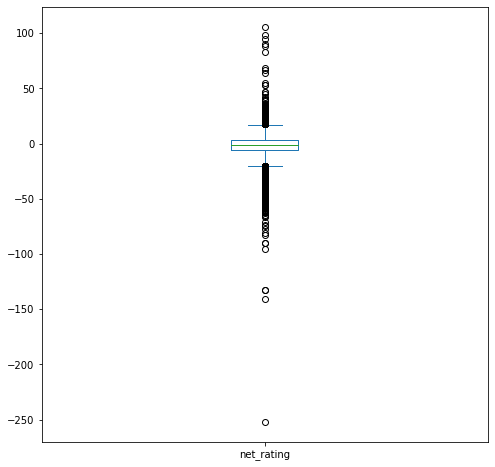

In [477]:
df['net_rating'].plot.box(figsize=(8,8))

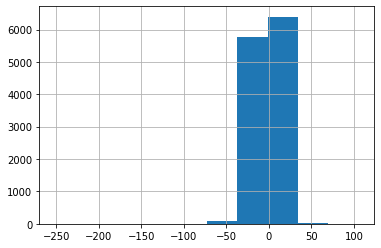

In [478]:
df['net_rating'].hist()

Observamos que há uma distribuição simétrica de net_rating, mas foi detectada a presença de outliers pelo boxplot (valores mais distantes do máximo e mínimo da caixa). Para tratá-los, vamos tentar utilizar o método de tukey.

In [479]:
q1 = df['net_rating'].quantile(q=0.25)
q3 = df['net_rating'].quantile(q=0.75)
iqr = q3 - q1
print(iqr)

9.425


In [480]:
df[df['net_rating'] < (q1-1.5*iqr)].shape

(386, 25)

In [481]:
# valore unicos de net_rating dos outliers inferiores detectados pelo metodo
df[df['net_rating'] < (q1-1.5*iqr)]['net_rating'].unique()

array([ -24. ,  -30.5,  -40.8,  -42.5,  -33.6,  -29.8,  -38.4,  -22.4,
        -24.2,  -42.1,  -53.7,  -57.4,  -47.4,  -52.7,  -36.2,  -29.9,
        -21.5,  -24.6,  -21.7,  -29.5,  -20.5,  -29.2,  -20.8,  -36.4,
        -30. ,  -38.9,  -64.9,  -23.9,  -28.8,  -65.1,  -20.4,  -21.6,
        -56.2,  -42.9,  -42.6,  -28.3,  -26.5,  -25.5,  -34. ,  -33.1,
        -23.8,  -36.1,  -29.7,  -27.2,  -21. ,  -33.4,  -25.7,  -30.9,
        -22.1,  -32.6,  -21.2,  -24.7,  -38. ,  -23.7,  -45.9,  -35. ,
        -35.2,  -22.5,  -41.6,  -25.6,  -39. ,  -23.1,  -42. ,  -20.7,
        -21.1,  -21.4,  -62.2,  -23. ,  -61.3,  -32.4,  -33.7,  -28.4,
        -38.7,  -51.9,  -22. ,  -26.2,  -46.1,  -40.5,  -66.7,  -61. ,
        -27.9,  -58.2,  -24.3,  -49. ,  -26.4,  -31.3,  -27.5,  -20.6,
        -25.2,  -27.8,  -24.4,  -34.4,  -26.6,  -26.8,  -27.7,  -23.2,
        -21.3,  -24.1,  -44.4,  -31.2,  -24.5,  -44.7, -140.5,  -44.1,
        -28.7,  -55.2,  -42.8,  -40. ,  -31.6,  -22.7,  -81. ,  -32.1,
      

In [482]:
# valore unicos de net_rating dos outliers superiores detectados pelo metodo
df[df['net_rating'] > (q3+1.5*iqr)]['net_rating'].unique()

array([ 17.5,  20.3,  27.4,  21.3,  24.9,  26.5,  26. ,  32.6,  26.9,
        23.7,  38.9,  18.8,  22.6,  46.4,  21.1,  22.5,  20.9,  24.5,
        39.1,  19.1,  41.9,  24.6,  21.8,  94.8,  20.5,  40.4,  17.9,
        21. ,  88.5,  21.5,  18. ,  23. ,  25.3,  35.9,  31.3,  19.4,
        35.6,  19.7,  23.8,  55.3,  17.6,  25. ,  28.6,  17.7,  19.5,
        32.5,  18.1,  27.1,  29.7,  22. ,  21.2,  34.7,  32.7,  18.9,
        24.4,  18.3,  31.7,  26.8,  44.9,  18.7,  46.9,  21.6,  27.3,
        30. ,  18.4,  30.9,  26.6,  66.7,  52.8,  63.9,  25.8,  26.7,
        23.1,  22.7,  33.9,  33.3,  29.9,  20.2, 105.8,  21.7,  32.8,
        29.8,  22.1,  34.1,  30.7,  39.5,  82.6,  68.9,  31.8,  98.7,
        33.8,  53. ,  22.4,  22.2,  90. ,  27.9,  19.2,  22.3,  29.3,
        17.8,  32. ,  30.5,  18.2])

Ao utilizar o conhecimento do domínio dos dados e desse atributo específico, entendemos que os outliers detectados pelo teste de tukey na verdade contêm valores aceitáveis para net_rating. Por isso, decidimos recorrer novamente ao z-score para a detecção e remoção de outliers:

In [483]:
net_rating_mean = df['net_rating'].mean() # media do atributo
net_rating_sd = df['net_rating'].std() # desvio padrao do atributo

In [484]:
net_rating_outliers = df[(abs(df['net_rating'] - net_rating_mean) / net_rating_sd) > 3.5] # obtendo os outliers a partir do z-score das amostras
net_rating_outliers.shape

(128, 25)

In [485]:
(net_rating_outliers['net_rating'].unique())

array([ -40.8,  -42.5,  -38.4,  -42.1,  -53.7,  -57.4,  -47.4,  -52.7,
        -38.9,  -64.9,  -65.1,  -56.2,  -42.9,  -42.6,   38.9,   46.4,
        -38. ,  -45.9,  -41.6,  -39. ,  -42. ,  -62.2,  -61.3,   39.1,
         41.9,  -38.7,  -51.9,  -46.1,  -40.5,   94.8,  -66.7,  -61. ,
        -58.2,   40.4,  -49. ,  -44.4,   88.5,  -44.7, -140.5,  -44.1,
        -55.2,  -42.8,  -40. ,  -81. ,   35.9,  -82.9,  -43.7,   35.6,
        -54. ,  -48.9,   55.3,  -40.1,  -75. ,  -38.8,  -40.9,  -74.1,
        -48.4,  -61.8,  -41. ,  -39.3,   34.7,  -60.3,  -71.1,  -41.8,
        -58. ,  -51.1,  -41.4,   44.9,   46.9,  -58.7,   66.7,   52.8,
        -40.7,  -95.6,   63.9,  -61.1,   33.9,   33.3,  -43.4,  -45.8,
        -50.9,  105.8,  -37.6,  -54.5,  -54.3,  -40.3,   34.1,  -90.3,
        -47.1,  -56.8,  -44.8,   39.5, -252.2,   82.6,   68.9,  -43.5,
        -45.7,  -60.1,   98.7,  -54.1, -132.8,   33.8,  -40.4,   53. ,
        -48. ,   90. ,  -44.6,  -62.4,  -48.6,  -77.5])

Cerca de 130 amostras são outliers com relação ao net_rating (possuem valores muito baixos ou muito acima do esperado). Por se tratar de um pequeno subconjunto dos nossos dados, essas ocorrências serão removidas.

In [486]:
df = df[(abs(df['net_rating'] - net_rating_mean) / net_rating_sd) <= 3.5]
df.reset_index(inplace=True, drop=True)

#### Rebounds pct (attack and defense), Usage rate, Assists pct

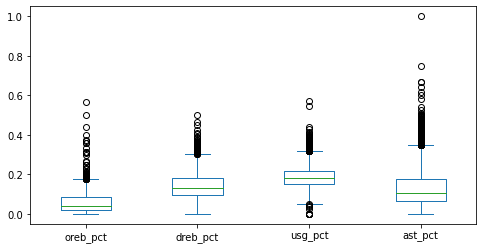

In [487]:
df[['oreb_pct', 'dreb_pct', 'usg_pct', 'ast_pct']].plot.box(figsize=(8,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f056ad4ec90>,
      dtype=object)

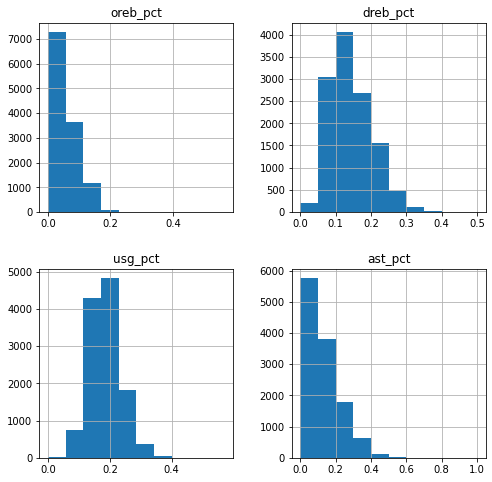

In [488]:
df[['oreb_pct', 'dreb_pct', 'usg_pct', 'ast_pct']].hist(figsize=(8,8))

Todos os 4 atributos analisados possuem outliers em suas amostras. Além disso, com base nos histogramas, também verificamos que oreb_pct e ast_pct não têm distribuição normal e por isso também vamos ajustá-los antes de partir para a remoção dos seus outliers.

##### oreb_pct

In [489]:
# Verificando se há valores nulos antes de aplicar o log na coluna
df['oreb_pct'].value_counts()

0.000    294
0.017    239
0.015    230
0.019    229
0.023    224
        ... 
0.212      1
0.200      1
0.269      1
0.400      1
0.232      1
Name: oreb_pct, Length: 219, dtype: int64

Cerca de 290 amostras possuem a taxa de offensive rebounds zerada. Devido a isso, testamos 3 abordagens de detecção de outliers:
- Remoção de zeros, aplicação de log e detecção com z-score robusto
- Substituição de zeros com valores pequenos, aplicação de log e detecção com z-score robusto
- Aplicação direta do z-score robusto nos dados sem distribuição simétrica

###### Remoção de zeros, aplicação de log e detecção com z-score robusto

In [490]:
# Removendo zeros
df_non_zero = df[df['oreb_pct'] > 0]
df_non_zero.reset_index(inplace=True, drop=True)

Agora vamos finalmente aplicar o log à coluna de oreb_pct:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


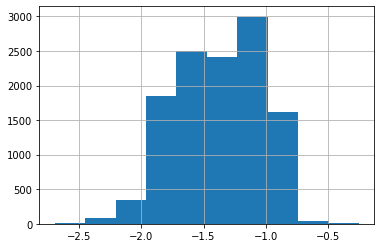

In [491]:
df_non_zero['oreb_pct_log'] = np.log10(df_non_zero['oreb_pct'])
df_non_zero['oreb_pct_log'].hist()

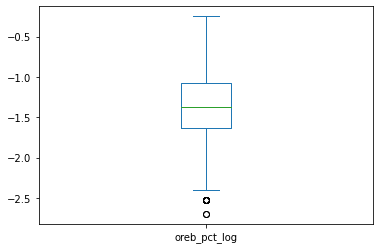

In [492]:
df_non_zero[['oreb_pct_log']].plot.box()

Agora observamos que há uma distribuição simétrica e vamos tratar seus outliers utilizando o z-score robusto.

In [493]:
oreb_pct_log_mad = abs(df_non_zero['oreb_pct_log'] - df_non_zero['oreb_pct_log'].median()).median()*(1/0.6745)

In [494]:
oreb_pct_log_outliers = df_non_zero[abs(df_non_zero['oreb_pct_log']-df_non_zero['oreb_pct_log'].median())/oreb_pct_log_mad > 3] # obtendo os outliers a partir do z-score robusto
oreb_pct_log_outliers

player_name team_abbreviation   age  player_height  player_weight  \
1190  Hubert Davis               DAL  29.0         195.58      83.007336   
2418   Dana Barros               DET  35.0         180.34      74.842680   

             college country  draft_year  draft_round  draft_number  ...  \
1190  North Carolina     USA      1992.0          1.0          20.0  ...   
2418  Boston College     USA      1989.0          1.0          16.0  ...   

      dreb_pct  usg_pct  ts_pct  ast_pct   season  undrafted  \
1190     0.072    0.162   0.545    0.108  1998-99        0.0   
2418     0.109    0.192   0.473    0.221  2001-02        0.0   

      season_start_year  season_end_year    gp_pct  oreb_pct_log  
1190               1998             1999  1.000000      -2.69897  
2418               2001             2002  0.353659      -2.69897  

[2 rows x 26 columns]

Apenas 2 amostras são outliers com relação ao oreb_pct_log (possuem valores muito baixos).

###### Substituição de zeros com valores pequenos, aplicação de log e detecção com z-score robusto

Cerca de 290 amostras possuem valores zerados, sendo esse o valor mais frequente na coluna. Como vamos aplicar o log nos dados na tentativa de normalizar sua distribuição, vamos substituir os valores nulos por valores muito pequenos considerando a escala do atributo em questão.

In [495]:
# Verificando o menor valor do atributo depois do 0
df['oreb_pct'].nsmallest(295)

26       0.000
73       0.000
143      0.000
418      0.000
468      0.000
         ...  
12132    0.000
12136    0.000
12138    0.000
12140    0.000
1208     0.002
Name: oreb_pct, Length: 295, dtype: float64

In [496]:
# Substituindo os zeros por valor muito pequeno
df['oreb_pct_non_zero'] = df['oreb_pct']
df.loc[df['oreb_pct_non_zero'] == 0,'oreb_pct_non_zero'] = 0.001

Agora vamos finalmente aplicar o log à coluna de oreb_pct:

In [497]:
df['oreb_pct_log'] = np.log10(df['oreb_pct_non_zero'])
df['oreb_pct_log'].hist()

In [498]:
df[['oreb_pct_log']].plot.box()

Agora observamos que há uma distribuição simétrica e vamos tratar seus outliers utilizando o z-score robusto.

In [499]:
oreb_pct_log_mad = abs(df['oreb_pct_log'] - df['oreb_pct_log'].median()).median()*(1/0.6745)

In [500]:
oreb_pct_log_outliers = df[abs(df['oreb_pct_log']-df['oreb_pct_log'].median())/oreb_pct_log_mad > 3] # obtendo os outliers a partir do z-score robusto
oreb_pct_log_outliers

player_name team_abbreviation   age  player_height  \
26         Matt Steigenga               CHI  27.0         200.66   
73          Jimmy Carruth               MIL  27.0         208.28   
143            Tim Legler               WAS  30.0         193.04   
418         Elmer Bennett               DEN  27.0         182.88   
468           Derek Grimm               SAC  23.0         205.74   
...                   ...               ...   ...            ...   
12106      Tremont Waters               WAS  24.0         178.00   
12132     Cassius Winston               WAS  23.0         185.00   
12136  McKinley Wright IV               MIN  23.0         183.00   
12138        Moses Wright               LAC  23.0         206.00   
12140           Gabe York               IND  28.0         190.00   

       player_weight         college country  draft_year  draft_round  \
26         102.05820  Michigan State     USA      1992.0          2.0   
73         120.20188   Virginia Tech     USA         NaN          NaN   
143         90.71840        La Salle     USA         NaN          NaN   
418         77.11064      Notre Dame     USA      1992.0          2.0   
468        104.32616        Missouri     USA         NaN          NaN   
...              ...             ...     ...         ...          ...   
12106       79.00000             LSU     USA      2019.0          2.0   
12132       83.00000  Michigan State     USA      2020.0          2.0   
12136       88.00000        Colorado     USA         NaN          NaN   
12138      105.00000    Georgia Tech     USA         NaN          NaN   
12140       83.00000         Arizona     USA         NaN          NaN   

       draft_number  ...  usg_pct  ts_pct  ast_pct   season  undrafted  \
26             52.0  ...    0.341   0.307    0.333  1996-97        0.0   
73              NaN  ...    0.103   0.727    0.000  1996-97        1.0   
143             NaN  ...    0.151   0.431    0.055  1996-97        1.0   
418            38.0  ...    0.187   0.470    0.216  1996-97        0.0   
468             NaN  ...    0.199   0.470    0.000  1997-98        1.0   
...             ...  ...      ...     ...      ...      ...        ...   
12106          51.0  ...    0.111   0.500    0.000  2021-22        0.0   
12132          53.0  ...    0.180   0.549    0.244  2021-22        0.0   
12136           NaN  ...    0.088   0.833    0.209  2021-22        1.0   
12138           NaN  ...    0.000   0.524    1.000  2021-22        1.0   
12140           NaN  ...    0.208   0.435    0.251  2021-22        1.0   

       season_start_year  season_end_year    gp_pct  oreb_pct_non_zero  \
26                  1996             1997  0.024390              0.001   
73                  1996             1997  0.048780              0.001   
143                 1996             1997  0.182927              0.001   
418                 1996             1997  0.109756              0.001   
468                 1997             1998  0.109756              0.001   
...                  ...              ...       ...                ...   
12106               2021             2022  0.012195              0.001   
12132               2021             2022  0.085366              0.001   
12136               2021             2022  0.060976              0.001   
12138               2021             2022  0.012195              0.001   
12140               2021             2022  0.024390              0.001   

       oreb_pct_log  
26             -3.0  
73             -3.0  
143            -3.0  
418            -3.0  
468            -3.0  
...             ...  
12106          -3.0  
12132          -3.0  
12136          -3.0  
12138          -3.0  
12140          -3.0  

[296 rows x 27 columns]

296 amostras são outliers com relação ao oreb_pct_log (possuem valores muito baixos). O resultado obtido corresponde ao primeiro método de remover os zeros (294) antes da normalização e a partir do z-score robusto remover mais 2 ocorências (=296). Vamos tentar ainda um último terceiro método.

###### Aplicação direta do z-score robusto nos dados sem distribuição simétrica

Cerca de 290 amostras possuem valores zerados, sendo esse o valor mais frequente na coluna. Apesar do histograma apontar para uma distribuição diferente da normal, vamos testar o uso direto do z-score robusto para detecção de outliers, dado o dilema das duas abordagens anteriores sobre como lidar com os valores zerados.

In [501]:
oreb_pct_mad = abs(df['oreb_pct'] - df['oreb_pct'].median()).median()*(1/0.6745)

In [502]:
oreb_pct_outliers = df[abs(df['oreb_pct']-df['oreb_pct'].median())/oreb_pct_mad > 3] # obtendo os outliers a partir do z-score robusto
oreb_pct_outliers

player_name team_abbreviation   age  player_height  \
18            Malik Rose               CHH  22.0         200.66   
68          Joe Stephens               HOU  24.0         200.66   
88     Larry Krystkowiak               LAL  32.0         205.74   
133          Will Perdue               SAS  31.0         213.36   
192      Shawnelle Scott               CLE  25.0         210.82   
...                  ...               ...   ...            ...   
12015        Chris Silva               MIA  25.0         203.00   
12016    Marko Simonovic               CHI  22.0         211.00   
12029        Jalen Smith               PHO  21.0         208.00   
12065   Tristan Thompson               SAC  30.0         206.00   
12115   Hassan Whiteside               UTA  32.0         213.00   

       player_weight               college     country  draft_year  \
18         113.39800                Drexel         USA      1996.0   
68          95.25432  Arkansas-Little Rock         USA         NaN   
88          99.79024               Montana         USA      1986.0   
133        108.86208            Vanderbilt         USA      1988.0   
192        113.39800       St. John's (NY)         USA      1994.0   
...              ...                   ...         ...         ...   
12015      106.00000        South Carolina       Gabon         NaN   
12016       97.00000                  None  Montenegro      2020.0   
12029       97.00000              Maryland         USA      2020.0   
12065      115.00000                 Texas         USA      2011.0   
12115      120.00000              Marshall         USA      2010.0   

       draft_round  draft_number  ...  usg_pct  ts_pct  ast_pct   season  \
18             2.0          44.0  ...    0.161   0.515    0.089  1996-97   
68             NaN           NaN  ...    0.279   0.300    0.000  1996-97   
88             2.0          28.0  ...    0.140   0.521    0.273  1996-97   
133            1.0          11.0  ...    0.139   0.582    0.033  1996-97   
192            2.0          43.0  ...    0.191   0.480    0.000  1996-97   
...            ...           ...  ...      ...     ...      ...      ...   
12015          NaN           NaN  ...    0.143   0.641    0.109  2021-22   
12016          2.0          44.0  ...    0.275   0.428    0.000  2021-22   
12029          1.0          10.0  ...    0.205   0.547    0.021  2021-22   
12065          1.0           4.0  ...    0.195   0.521    0.059  2021-22   
12115          2.0          33.0  ...    0.171   0.662    0.034  2021-22   

       undrafted  season_start_year  season_end_year    gp_pct  \
18           0.0               1996             1997  0.658537   
68           1.0               1996             1997  0.024390   
88           0.0               1996             1997  0.036585   
133          0.0               1996             1997  0.792683   
192          0.0               1996             1997  0.195122   
...          ...                ...              ...       ...   
12015        1.0               2021             2022  0.109756   
12016        0.0               2021             2022  0.109756   
12029        0.0               2021             2022  0.353659   
12065        0.0               2021             2022  0.365854   
12115        0.0               2021             2022  0.792683   

       oreb_pct_non_zero  oreb_pct_log  
18                 0.169     -0.772113  
68                 0.250     -0.602060  
88                 0.182     -0.739929  
133                0.155     -0.809668  
192                0.160     -0.795880  
...                  ...           ...  
12015              0.170     -0.769551  
12016              0.162     -0.790485  
12029              0.159     -0.798603  
12065              0.171     -0.767004  
12115              0.162     -0.790485  

[176 rows x 27 columns]

176 amostras são outliers com relação ao oreb_pct_log (possuem valores em tese acima do esperado), mas na verdade essas ocorrências não correspondem a outliers, e sim a jogadores que se destacam na métrica (conhecimento do domínio).

###### Conclusão

Após testar as 3 abordagens, os resultados mais razoáveis na detecção de outliers quando há amostras zeradas foram obtidos com a remoção dos zeros antes da normalização. Por isso, esse método será adotado para os futuros cenários semelhantes, se existirem.

Vamos aplicar a abordagem escolhida:

In [503]:
# Removendo zeros
df = df[df['oreb_pct'] > 0]
df.reset_index(inplace=True, drop=True)

In [504]:
# Aplicando o log
df['oreb_pct_log'] = np.log10(df['oreb_pct'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [505]:
# Outliers (z-score robusto)
oreb_pct_log_mad = abs(df['oreb_pct_log'] - df['oreb_pct_log'].median()).median()*(1/0.6745)
oreb_pct_log_outliers = df[abs(df['oreb_pct_log']-df['oreb_pct_log'].median())/oreb_pct_log_mad > 3] # obtendo os outliers a partir do z-score robusto
oreb_pct_log_outliers

player_name team_abbreviation   age  player_height  player_weight  \
1190  Hubert Davis               DAL  29.0         195.58      83.007336   
2418   Dana Barros               DET  35.0         180.34      74.842680   

             college country  draft_year  draft_round  draft_number  ...  \
1190  North Carolina     USA      1992.0          1.0          20.0  ...   
2418  Boston College     USA      1989.0          1.0          16.0  ...   

      usg_pct  ts_pct  ast_pct   season  undrafted  season_start_year  \
1190    0.162   0.545    0.108  1998-99        0.0               1998   
2418    0.192   0.473    0.221  2001-02        0.0               2001   

      season_end_year    gp_pct  oreb_pct_non_zero  oreb_pct_log  
1190             1999  1.000000              0.002      -2.69897  
2418             2002  0.353659              0.002      -2.69897  

[2 rows x 27 columns]

In [506]:
# Removendo outliers
df = df[abs(df['oreb_pct_log']-df['oreb_pct_log'].median())/oreb_pct_log_mad <= 3]
df.reset_index(inplace=True, drop=True)

##### ast_pct

In [507]:
# Verificando se há valores nulos antes de aplicar o log na coluna
df['ast_pct'].value_counts()

0.000    162
0.068    112
0.063    107
0.077    100
0.074     98
        ... 
0.413      1
0.438      1
0.415      1
0.491      1
0.641      1
Name: ast_pct, Length: 474, dtype: int64

Cerca de 160 amostras possuem ast_pct zerada, sendo esse o valor mais frequente na coluna. Como decidimos aplicar o log nos dados na tentativa de normalizar sua distribuição, vamos remover os valores nulos existentes.

In [508]:
# Removendo zeros
df = df[df['ast_pct'] > 0]
df.reset_index(inplace=True, drop=True)

Agora vamos finalmente aplicar o log:

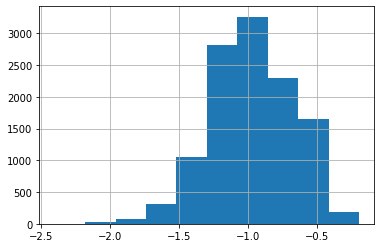

In [509]:
df['ast_pct_log'] = np.log10(df['ast_pct'])
df['ast_pct_log'].hist()

Agora observamos que há uma distribuição simétrica e vamos tratar seus outliers utilizando o z-score robusto.

In [510]:
# Outliers (z-score robusto)
ast_pct_log_mad = abs(df['ast_pct_log'] - df['ast_pct_log'].median()).median()*(1/0.6745)
ast_pct_log_outliers = df[abs(df['ast_pct_log']-df['ast_pct_log'].median())/ast_pct_log_mad > 3]
ast_pct_log_outliers

player_name team_abbreviation   age  player_height  \
964    William Cunningham               NJN  25.0         210.82   
1007        Brian Skinner               LAC  23.0         205.74   
1170         Jahidi White               WAS  23.0         205.74   
1740       Joel Przybilla               MIL  21.0         215.90   
1980      Soumaila Samake               NJN  23.0         213.36   
2870          Etan Thomas               WAS  25.0         208.28   
3325             Pape Sow               TOR  23.0         208.28   
3628         Jared Reiner               CHI  23.0         210.82   
3643         Jahidi White               CHA  29.0         205.74   
3812                Ha Ha               POR  20.0         220.98   
3834         James Thomas               CHI  25.0         205.74   
3866        Danny Fortson               SEA  30.0         203.20   
3868      Dikembe Mutombo               HOU  40.0         218.44   
3954         Robert Swift               SEA  20.0         213.36   
4216        Danny Fortson               SEA  31.0         203.20   
4426         Ryan Hollins               CHA  22.0         213.36   
4521      Justin Williams               SAC  23.0         208.28   
4524        Jumaine Jones               PHX  28.0         203.20   
4646         Joel Anthony               MIA  25.0         205.74   
4983      Dikembe Mutombo               HOU  42.0         218.44   
5054     Oleksiy Pecherov               WAS  23.0         213.36   
5453          Robin Lopez               PHX  22.0         213.36   
5528        Sean Williams               NJN  23.0         208.28   
5775      Jamaal Magloire               MIA  32.0         210.82   
5800           Jeff Ayres               POR  23.0         205.74   
5855          Etan Thomas               OKC  32.0         208.28   
6027          Robin Lopez               PHX  23.0         213.36   
6203            Ike Diogu               LAC  27.0         205.74   
6637         Joel Anthony               MIA  29.0         205.74   
7475      Bismack Biyombo               CHA  21.0         205.74   
7598            Greg Oden               MIA  26.0         213.36   
7604      Hasheem Thabeet               OKC  27.0         220.98   
7858     Hassan Whiteside               MIA  26.0         213.36   
11081         Moses Brown               TOT  22.0         218.00   
11082         Moses Brown               DAL  22.0         218.00   
11197      Melvin Frazier               OKC  25.0         196.00   

       player_weight              college                           country  \
964       108.862080               Temple                               USA   
1007      115.665960               Baylor                               USA   
1170      131.541680           Georgetown                               USA   
1740      115.665960            Minnesota                               USA   
1980      101.604608                 None                              Mali   
2870      117.933920             Syracuse                               USA   
3325      113.398000  Cal State-Fullerton                           Senegal   
3628      115.665960                 Iowa                               USA   
3643      131.541680           Georgetown                               USA   
3812      138.345560         Yonsei (KOR)                       South Korea   
3834      111.130040                Texas                               USA   
3866      117.933920           Cincinnati                               USA   
3868      120.201880           Georgetown                             Congo   
3954      111.130040                 None                               USA   
4216      117.933920           Cincinnati                               USA   
4426      104.326160                 UCLA                               USA   
4521      104.326160              Wyoming                               USA   
4524      104.326160              Georgia                               USA

In [511]:
# Removendo outliers
df = df[abs(df['ast_pct_log']-df['ast_pct_log'].median())/ast_pct_log_mad <= 3]
df.reset_index(inplace=True, drop=True)

##### dreb_pct

Como observamos que há uma distribuição simétrica, já vamos tratar seus outliers utilizando o z-score robusto.

In [512]:
# Outliers (z-score robusto)
dreb_pct_mad = abs(df['dreb_pct'] - df['dreb_pct'].median()).median()*(1/0.6745)
dreb_pct_outliers = df[abs(df['dreb_pct']-df['dreb_pct'].median())/dreb_pct_mad > 3]
dreb_pct_outliers

player_name team_abbreviation   age  player_height  \
391        Dennis Rodman               CHI  36.0         198.12   
462        Dennis Rodman               CHI  37.0         198.12   
481         Jason Lawson               ORL  23.0         210.82   
844        Danny Fortson               DEN  23.0         200.66   
855        Dennis Rodman               LAL  38.0         200.66   
...                  ...               ...   ...            ...   
11450     Eugene Omoruyi               DAL  24.0         201.00   
11596  Jonas Valančiūnas               NOP  29.0         211.00   
11603     Nikola Vučević               CHI  31.0         208.00   
11637        D.J. Wilson               TOR  25.0         208.00   
11651     Omer Yurtseven               MIA  23.0         213.00   

       player_weight                      college      country  draft_year  \
391         99.79024  Southeastern Oklahoma State          USA      1986.0   
462         99.79024  Southeastern Oklahoma State          USA      1986.0   
481        108.86208                    Villanova          USA      1997.0   
844        117.93392                   Cincinnati          USA      1997.0   
855         95.25432  Southeastern Oklahoma State          USA      1986.0   
...              ...                          ...          ...         ...   
11450      110.00000           Rutgers University      Nigeria         NaN   
11596      120.00000                         None    Lithuania      2011.0   
11603      117.00000                          USC  Switzerland      2011.0   
11637      104.00000                     Michigan          USA      2017.0   
11651      119.00000                     NC State       Turkey         NaN   

       draft_round  draft_number  ...  ts_pct  ast_pct   season  undrafted  \
391            2.0          27.0  ...   0.479    0.113  1996-97        0.0   
462            2.0          27.0  ...   0.459    0.112  1997-98        0.0   
481            2.0          41.0  ...   0.670    0.083  1997-98        0.0   
844            1.0          10.0  ...   0.564    0.038  1998-99        0.0   
855            2.0          27.0  ...   0.388    0.063  1998-99        0.0   
...            ...           ...  ...     ...      ...      ...        ...   
11450          NaN           NaN  ...   0.518    0.158  2021-22        1.0   
11596          1.0           5.0  ...   0.617    0.140  2021-22        0.0   
11603          1.0          16.0  ...   0.533    0.152  2021-22        0.0   
11637          1.0          17.0  ...   0.773    0.146  2021-22        0.0   
11651          NaN           NaN  ...   0.546    0.110  2021-22        1.0   

       season_start_year  season_end_year    gp_pct  oreb_pct_non_zero  \
391                 1996             1997  0.670732              0.186   
462                 1997             1998  0.975610              0.169   
481                 1997             1998  0.207317              0.104   
844                 1998             1999  1.000000              0.167   
855                 1998             1999  0.460000              0.114   
...                  ...              ...       ...                ...   
11450               2021             2022  0.048780              0.123   
11596               2021             2022  0.902439              0.109   
11603               2021             2022  0.890244              0.066   
11637               2021             2022  0.048780              0.019   
11651               2021             2022  0.682927              0.139   

       oreb_pct_log  ast_pct_log  
391       -0.730487    -0.946922  
462       -0.772113    -0.950782  
481       -0.982967    -1.080922  
844       -0.777284    -1.420216  
855       -0.943095    -1.200659  
...             ...          ...  
11450     -0.910095    -0.801343  
11596     -0.962574    -0.853872  
11603     -1.180456    -0.818156  
11637     -1.721246    -0.835647  
11651     -0.856985    -0.958607  

[90 rows x 28 columns]

Apesar de terem sido reconhecidos 90 outliers, por conhecimento do domínio dos dados, foi percebido que as amostras na verdade se tratam de jogadores que se destacam na métrica em questão. Portanto, essas ocorrências não serão removidas do dataset.

##### usg_pct

Como observamos que há uma distribuição simétrica, já vamos tratar seus outliers utilizando o z-score robusto.

In [513]:
# Outliers (z-score robusto)
usg_pct_mad = abs(df['usg_pct'] - df['usg_pct'].median()).median()*(1/0.6745)
usg_pct_outliers = df[abs(df['usg_pct']-df['usg_pct'].median())/usg_pct_mad > 3]
usg_pct_outliers

player_name team_abbreviation   age  player_height  player_weight  \
45       Michael Jordan               CHI  34.0         198.12      97.975872   
225       Charles Jones               HOU  40.0         205.74      97.522280   
241      David Robinson               SAS  31.0         215.90     106.594120   
485      Horacio Llamas               PHX  24.0         210.82     129.273720   
628    Shaquille O'Neal               LAL  26.0         215.90     142.881480   
...                 ...               ...   ...            ...            ...   
11178       Paul George               LAC  31.0         203.00      99.000000   
11365  Boban Marjanović               DAL  33.0         221.00     131.000000   
11401  Donovan Mitchell               UTA  25.0         185.00      97.000000   
11411         Ja Morant               MEM  22.0         190.00      78.000000   
11650        Trae Young               ATL  23.0         185.00      74.000000   

                 college country  draft_year  draft_round  draft_number  ...  \
45        North Carolina     USA      1984.0          1.0           3.0  ...   
225    Albany State (GA)     USA      1979.0          8.0         165.0  ...   
241                 Navy     USA      1987.0          1.0           1.0  ...   
485         Grand Canyon     USA         NaN          NaN           NaN  ...   
628      Louisiana State     USA      1992.0          1.0           1.0  ...   
...                  ...     ...         ...          ...           ...  ...   
11178       Fresno State     USA      2010.0          1.0          10.0  ...   
11365               None  Serbia         NaN          NaN           NaN  ...   
11401         Louisville     USA      2017.0          1.0          13.0  ...   
11411       Murray State     USA      2019.0          1.0           2.0  ...   
11650           Oklahoma     USA      2018.0          1.0           5.0  ...   

       ts_pct  ast_pct   season  undrafted  season_start_year  \
45      0.567    0.208  1996-97        0.0               1996   
225     0.400    0.046  1996-97        0.0               1996   
241     0.559    0.111  1996-97        0.0               1996   
485     0.472    0.034  1997-98        1.0               1997   
628     0.587    0.125  1997-98        0.0               1997   
...       ...      ...      ...        ...                ...   
11178   0.538    0.281  2021-22        0.0               2021   
11365   0.615    0.048  2021-22        1.0               2021   
11401   0.572    0.277  2021-22        0.0               2021   
11411   0.575    0.341  2021-22        0.0               2021   
11650   0.603    0.467  2021-22        0.0               2021   

       season_end_year    gp_pct  oreb_pct_non_zero  oreb_pct_log  ast_pct_log  
45                1997  1.000000              0.042     -1.376751    -0.681937  
225               1997  0.146341              0.068     -1.167491    -1.337242  
241               1997  0.073171              0.161     -0.793174    -0.954677  
485               1998  0.097561              0.108     -0.966576    -1.468521  
628               1998  0.731707              0.114     -0.943095    -0.903090  
...                ...       ...                ...           ...          ...  
11178             2022  0.378049              0.012     -1.920819    -0.551294  
11365             2022  0.280488              0.069     -1.161151    -1.318759  
11401             2022  0.817073              0.027     -1.568636    -0.557520  
11411             2022  0.695122              0.042     -1.376751    -0.467246  
11650             2022  0.926829              0.021     -1.677781    -0.330683  

[79 rows x 28 columns]

Apesar de terem sido reconhecidos 79 outliers, por conhecimento do domínio dos dados, foi percebido que as amostras na verdade se tratam de jogadores que se destacam na métrica em questão. Portanto, essas ocorrências não serão removidas do dataset.

#### Pontos por Jogo (bivariado)

In [514]:
df['pts'].plot.box()

In [515]:
df['pts'].hist()

Verificamos que o atributo não tem distribuição normal e por isso vamos ajustá-lo antes de partir para a remoção dos seus outliers.

In [516]:
# Verificando se há valores nulos antes de aplicar o log na coluna
0 in df['pts'].unique()

False

Como não há valores nulos, podemos aplicar o log à coluna:

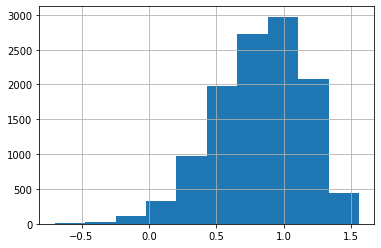

In [517]:
df['pts_log'] = np.log10(df['pts'])
df['pts_log'].hist()

In [518]:
df[['pts_log']].plot.box()

Agora observamos que há uma distribuição simétrica e vamos tratar seus outliers utilizando o z-score robusto.

In [519]:
pts_log_mad = abs(df['pts_log'] - df['pts_log'].median()).median()*(1/0.6745)
pts_log_mad

0.3448074351491913

In [520]:
df[abs(df['pts_log']-df['pts_log'].median())/pts_log_mad > 3.5]

player_name team_abbreviation   age  player_height  \
86      LaSalle Thompson               IND  36.0         208.28   
136          Tim Kempton               SAS  33.0         208.28   
225        Charles Jones               HOU  40.0         205.74   
732      Kevin Salvadori               SAC  27.0         213.36   
2203      Jamison Brewer               IND  21.0         187.96   
3264        Hubert Davis               NJN  34.0         195.58   
3310           Mark Pope               DEN  32.0         208.28   
5021         Mark Madsen               MIN  33.0         205.74   
5941       Patrick Ewing               NOH  27.0         203.20   
6017   Pops Mensah-Bonsu               NOH  27.0         205.74   
7044      Joel Przybilla               MIL  33.0         215.90   
7183       Ronnie Brewer               CHI  29.0         200.66   
7571       Hamady Ndiaye               SAC  27.0         213.36   
8533     Michael Gbinije               DET  25.0         200.66   
9398        Nate Wolters               UTA  27.0         193.04   
10986         Joel Ayayi               WAS  21.0         196.00   
11451           Miye Oni               UTA  24.0         196.00   

       player_weight             college  country  draft_year  draft_round  \
86        111.130040               Texas      USA      1982.0          1.0   
136       111.130040          Notre Dame      USA      1986.0          6.0   
225        97.522280   Albany State (GA)      USA      1979.0          8.0   
732       104.779752      North Carolina      USA         NaN          NaN   
2203       80.739376              Auburn      USA      2001.0          2.0   
3264       83.007336      North Carolina      USA      1992.0          1.0   
3310      106.594120            Kentucky      USA      1996.0          2.0   
5021      115.665960            Stanford      USA      2000.0          1.0   
5941      106.594120          Georgetown      USA      2008.0          2.0   
6017      106.594120   George Washington      USA         NaN          NaN   
7044      111.130040           Minnesota      USA      2000.0          1.0   
7183      106.594120            Arkansas      USA      2006.0          1.0   
7571      106.594120             Rutgers  Senegal      2010.0          2.0   
8533       90.718400            Syracuse      USA      2016.0          2.0   
9398       86.182480  South Dakota State      USA      2013.0          2.0   
10986      81.000000             Gonzaga   France         NaN          NaN   
11451      93.000000                Yale      USA      2019.0          2.0   

       draft_number  ...  ast_pct   season  undrafted  season_start_year  \
86              5.0  ...    0.024  1996-97        0.0               1996   
136           124.0  ...    0.061  1996-97        0.0               1996   
225           165.0  ...    0.046  1996-97        0.0               1996   
732             NaN  ...    0.051  1997-98        1.0               1997   
2203           40.0  ...    0.321  2001-02        0.0               2001   
3264           20.0  ...    0.083  2003-04        0.0               2003   
3310           52.0  ...    0.063  2004-05        0.0               2004   
5021           29.0  ...    0.044  2008-09        0.0               2008   
5941           43.0  ...    0.167  2010-11        0.0               2010   
6017            NaN  ...    0.080  2010-11        1.0               2010   
7044            9.0  ...    0.080  2012-13        0.0               2012   
7183           14.0  ...    0.085  2013-14        0.0               2013   
7571           56.0  ...    0.065  2013-14        0.0               2013   
8533           49.0  ...    0.087  2016-17        0.0               2016   
9398           38.0  ...    0.077  2017-18        0.0               2017   
10986           NaN  ...    0.254  2021-22        1.0               2021   
11451          58.0  ...    0.142  2021-22        0.0               2021   

       season_end_year    gp_pct

Cerca de 20 amostras foram detectadas como outliers e correspondem a jogadores com pontos por jogo abaixo do esperado. Portanto, elas serão removidas do dataframe.

In [521]:
df = df[abs(df['pts_log']-df['pts_log'].median())/pts_log_mad <= 3.5]
df.shape

(11637, 29)

#### Assistências por Jogo (bivariado)

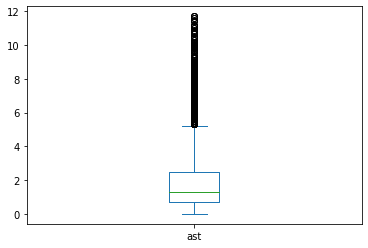

In [522]:
df['ast'].plot.box()

In [523]:
df['ast'].hist()

Verificamos que o atributo não tem distribuição normal e por isso vamos ajustá-lo antes de partir para a remoção dos seus outliers.

In [524]:
0 in df['ast'].unique()

True

Vamos remover os valores nulos da coluna antes do log:

In [525]:
df = df[df['ast'] > 0.]

Agora podemos aplicar o log à coluna:

In [526]:
df['ast_log'] = np.log10(df['ast'])
df['ast_log'].hist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Agora observamos que há uma distribuição normalizada e vamos tratar seus outliers utilizando o z-score robusto.

In [527]:
ast_log_mad = abs(df['ast_log'] - df['ast_log'].median()).median()*(1/0.6745)
ast_log_mad

0.42104767437390783

In [528]:
df[abs(df['ast_log']-df['ast_log'].median())/ast_log_mad > 3]

Empty DataFrame
Columns: [player_name, team_abbreviation, age, player_height, player_weight, college, country, draft_year, draft_round, draft_number, gp, pts, reb, ast, net_rating, oreb_pct, dreb_pct, usg_pct, ts_pct, ast_pct, season, undrafted, season_start_year, season_end_year, gp_pct, oreb_pct_non_zero, oreb_pct_log, ast_pct_log, pts_log, ast_log]
Index: []

[0 rows x 30 columns]

In [529]:
df['ast_log'].plot.box()

Outliers não detectados.

#### Rebotes por Jogo (bivariado)

In [530]:
df['reb'].plot.box()

In [531]:
df['reb'].hist()

Verificamos que o atributo não tem uma distribuição normal e por isso vamos ajustá-lo antes de partir para a remoção dos seus outliers.

In [532]:
0 in df['reb'].unique()

False

Como não há valores nulos, podemos aplicar o log à coluna:


In [533]:
df['reb_log'] = np.log10(df['reb'])
df['reb_log'].hist()

Agora observamos que há uma distribuição normalizada e vamos tratar seus outliers utilizando o z-score robusto.


In [534]:
reb_log_mad = abs(df['reb_log'] - df['reb_log'].median()).median()*(1/0.6745)
reb_log_mad

0.30010407379989673

In [535]:
df[abs(df['reb_log']-df['reb_log'].median())/reb_log_mad > 3.5]

player_name team_abbreviation   age  player_height  player_weight  \
744     Lawrence Moten               WAS  26.0         195.58      83.914520   
2377      Damone Brown               PHI  23.0         203.20      91.625584   
2906         Ndudi Ebi               MIN  20.0         205.74      90.718400   
3382       Luis Flores               DEN  24.0         187.96      88.450440   
3706     Geno Carlisle               POR  28.0         190.50      90.718400   
5455       Patty Mills               POR  21.0         182.88      83.914520   
7943      Toure' Murry               UTA  25.0         195.58      88.450440   
9279    Xavier Munford               MIL  26.0         193.04      78.471416   
9823   Brandon Goodwin               DEN  23.0         187.96      81.646560   
10342     Khyri Thomas               DET  24.0         190.50      95.254320   

                 college    country  draft_year  draft_round  draft_number  \
744             Syracuse        USA      1995.0          2.0          36.0   
2377            Syracuse        USA      2001.0          2.0          36.0   
2906                None        USA      2003.0          1.0          26.0   
3382           Manhattan        USA      2004.0          2.0          55.0   
3706          California        USA         NaN          NaN           NaN   
5455   Saint Mary's (CA)  Australia      2009.0          2.0          55.0   
7943       Wichita State        USA         NaN          NaN           NaN   
9279        Rhode Island        USA         NaN          NaN           NaN   
9823                None        USA         NaN          NaN           NaN   
10342          Creighton        USA      2018.0          2.0          38.0   

       ...  undrafted  season_start_year  season_end_year    gp_pct  \
744    ...        0.0               1997             1998  0.097561   
2377   ...        0.0               2001             2002  0.207317   
2906   ...        0.0               2003             2004  0.207317   
3382   ...        0.0               2004             2005  0.195122   
3706   ...        1.0               2004             2005  0.073171   
5455   ...        0.0               2009             2010  0.121951   
7943   ...        1.0               2014             2015  0.060976   
9279   ...        1.0               2017             2018  0.073171   
9823   ...        1.0               2018             2019  0.195122   
10342  ...        0.0               2019             2020  0.111111   

       oreb_pct_non_zero  oreb_pct_log  ast_pct_log   pts_log   ast_log  \
744                0.034     -1.468521    -0.669586  0.041393 -0.397940   
2377               0.037     -1.431798    -1.292430  0.146128 -1.000000   
2906               0.074     -1.130768    -0.698970 -0.096910 -0.698970   
3382               0.015     -1.823909    -0.581699  0.342423 -0.154902   
3706               0.071     -1.148742    -0.954677  0.113943 -0.698970   
5455               0.031     -1.508638    -0.602060  0.414973 -0.301030   
7943               0.067     -1.173925    -0.954677  0.079181 -0.698970   
9279               0.050     -1.301030    -0.438899 -0.301030 -0.154902   
9823               0.016     -1.795880    -0.525784  0.146128 -0.045757   
10342              0.012     -1.920819    -1.013228  0.322219 -0.397940   

       reb_log  
744   -1.00000  
2377  -0.69897  
2906  -0.69897  
3382  -0.69897  
3706  -0.69897  
5455  -0.69897  
7943  -0.69897  
9279  -0.69897  
9823  -0.69897  
10342 -1.00000  

[10 rows x 31 columns]

Cerca de 10 amostras foram detectadas como outliers e correspondem a jogadores com rebs por jogo abaixo do esperado. Portanto, elas serão removidas do dataframe.


In [536]:
df = df[abs(df['reb_log']-df['reb_log'].median())/reb_log_mad <= 3.5]
df.shape

(11621, 31)

#### Multivariado

In [537]:
df.columns

Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season', 'undrafted',
       'season_start_year', 'season_end_year', 'gp_pct', 'oreb_pct_non_zero',
       'oreb_pct_log', 'ast_pct_log', 'pts_log', 'ast_log', 'reb_log'],
      dtype='object')

Codificando os valores de cada atributo categórico com um encoder (possui métodos de transform e inverse_transform para não perder os valores categóricos originais).

In [538]:
categorical_features = ['player_name', 'team_abbreviation', 'college', 'country', 'season']
encoders = dict()
for cat in categorical_features:
    encoders[cat] = preprocessing.LabelEncoder()
    df[cat] = encoders[cat].fit_transform(df[cat].tolist())

Elegendo atributos que não possuem dados nulos

In [539]:
df_no_nan = df[['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season', 'undrafted',
       'season_start_year', 'season_end_year']]

Identificando outliers com o EllipticEnvelope

In [540]:
outlier_detector = EllipticEnvelope(contamination=0.01)
outlier_detector.fit(df_no_nan)

EllipticEnvelope(contamination=0.01)

In [541]:
# predict returns 1 for an inlier and -1 for an outlier
scores = outlier_detector.predict(df_no_nan)

In [542]:
scores

array([1, 1, 1, ..., 1, 1, 1])

In [543]:
df['outlier'] = scores

Outliers com atributos categóricos codificados

In [544]:
df[df['outlier'] == -1]

player_name  team_abbreviation   age  player_height  player_weight  \
1690          1856                 34  27.0         208.28      122.46984   
1706          1714                 28  24.0         193.04       88.45044   
2555          1427                 33  25.0         198.12       95.25432   
2968          1427                 33  26.0         198.12       95.25432   
3373          1427                 33  27.0         198.12       92.98636   
...            ...                ...   ...            ...            ...   
11148          254                 36  23.0         206.00      108.00000   
11149          254                  2  23.0         206.00      108.00000   
11150          254                 13  23.0         206.00      108.00000   
11272         1318                  3  29.0         188.00       88.00000   
11395         1700                  3  33.0         185.00       81.00000   

       college  country  draft_year  draft_round  draft_number  ...  \
1690       191        1         NaN          NaN           NaN  ...   
1706       282        1         NaN          NaN           NaN  ...   
2555       191        1      1999.0          2.0          57.0  ...   
2968       191        1      1999.0          2.0          57.0  ...   
3373       191        1      1999.0          2.0          57.0  ...   
...        ...      ...         ...          ...           ...  ...   
11148      152        0      2019.0          2.0          34.0  ...   
11149      152        0      2019.0          2.0          34.0  ...   
11150      152        0      2019.0          2.0          34.0  ...   
11272       78        2      2011.0          1.0           1.0  ...   
11395      245        2      2009.0          2.0          55.0  ...   

       season_start_year  season_end_year    gp_pct  oreb_pct_non_zero  \
1690                2000             2001  0.414634              0.043   
1706                2000             2001  0.353659              0.023   
2555                2002             2003  0.841463              0.039   
2968                2003             2004  0.939024              0.043   
3373                2004             2005  0.902439              0.041   
...                  ...              ...       ...                ...   
11148               2021             2022  0.365854              0.130   
11149               2021             2022  0.243902              0.134   
11150               2021             2022  0.121951              0.128   
11272               2021             2022  0.353659              0.016   
11395               2021             2022  0.987805              0.009   

       oreb_pct_log  ast_pct_log   pts_log   ast_log   reb_log  outlier  
1690      -1.366532    -1.823909  0.342423 -1.000000  0.146128       -1  
1706      -1.638272    -0.395774 -0.154902  0.146128 -0.301030       -1  
2555      -1.408935    -0.787812  0.880814  0.301030  0.361728       -1  
2968      -1.366532    -0.661544  1.107210  0.579784  0.653213       -1  
3373      -1.387216    -0.663540  1.204120  0.591065  0.643453       -1  
...             ...          ...       ...       ...       ...      ...  
11148     -0.886057    -1.124939  0.462398 -0.698970  0.255273       -1  
11149     -0.872895    -1.017729  0.000000 -0.698970 -0.096910       -1  
11150     -0.892790    -1.200659  0.838849 -0.522879  0.602060       -1  
11272     -1.795880    -0.598599  1.437751  0.763428  0.643453       -1  
11395     -2.045757    -0.974694  1.056905  0.361728  0.278754       -1  

[117 rows x 32 columns]

Outliers com atributos categóricos decodificados

In [545]:
for cat in categorical_features:
    df[cat] = encoders[cat].inverse_transform(df[cat].tolist())

In [546]:
df[df['outlier'] == -1]

player_name team_abbreviation   age  player_height  player_weight  \
1690   Ruben Wolkowyski               SEA  27.0         208.28      122.46984   
1706       Pepe Sanchez               PHI  24.0         193.04       88.45044   
2555      Manu Ginobili               SAS  25.0         198.12       95.25432   
2968      Manu Ginobili               SAS  26.0         198.12       95.25432   
3373      Manu Ginobili               SAS  27.0         198.12       92.98636   
...                 ...               ...   ...            ...            ...   
11148    Bruno Fernando               TOT  23.0         206.00      108.00000   
11149    Bruno Fernando               BOS  23.0         206.00      108.00000   
11150    Bruno Fernando               HOU  23.0         206.00      108.00000   
11272      Kyrie Irving               BRK  29.0         188.00       88.00000   
11395       Patty Mills               BRK  33.0         185.00       81.00000   

            college    country  draft_year  draft_round  draft_number  ...  \
1690           None  Argentina         NaN          NaN           NaN  ...   
1706         Temple  Argentina         NaN          NaN           NaN  ...   
2555           None  Argentina      1999.0          2.0          57.0  ...   
2968           None  Argentina      1999.0          2.0          57.0  ...   
3373           None  Argentina      1999.0          2.0          57.0  ...   
...             ...        ...         ...          ...           ...  ...   
11148      Maryland     Angola      2019.0          2.0          34.0  ...   
11149      Maryland     Angola      2019.0          2.0          34.0  ...   
11150      Maryland     Angola      2019.0          2.0          34.0  ...   
11272          Duke  Australia      2011.0          1.0           1.0  ...   
11395  Saint Mary's  Australia      2009.0          2.0          55.0  ...   

       season_start_year  season_end_year    gp_pct  oreb_pct_non_zero  \
1690                2000             2001  0.414634              0.043   
1706                2000             2001  0.353659              0.023   
2555                2002             2003  0.841463              0.039   
2968                2003             2004  0.939024              0.043   
3373                2004             2005  0.902439              0.041   
...                  ...              ...       ...                ...   
11148               2021             2022  0.365854              0.130   
11149               2021             2022  0.243902              0.134   
11150               2021             2022  0.121951              0.128   
11272               2021             2022  0.353659              0.016   
11395               2021             2022  0.987805              0.009   

       oreb_pct_log  ast_pct_log   pts_log   ast_log   reb_log  outlier  
1690      -1.366532    -1.823909  0.342423 -1.000000  0.146128       -1  
1706      -1.638272    -0.395774 -0.154902  0.146128 -0.301030       -1  
2555      -1.408935    -0.787812  0.880814  0.301030  0.361728       -1  
2968      -1.366532    -0.661544  1.107210  0.579784  0.653213       -1  
3373      -1.387216    -0.663540  1.204120  0.591065  0.643453       -1  
...             ...          ...       ...       ...       ...      ...  
11148     -0.886057    -1.124939  0.462398 -0.698970  0.255273       -1  
11149     -0.872895    -1.017729  0.000000 -0.698970 -0.096910       -1  
11150     -0.892790    -1.200659  0.838849 -0.522879  0.602060       -1  
11272     -1.795880    -0.598599  1.437751  0.763428  0.643453       -1  
11395     -2.045757    -0.974694  1.056905  0.361728  0.278754       -1  

[117 rows x 32 columns]

Removendo outliers do dataframe

In [547]:
df = df[df['outlier'] != -1]
df.shape

(11504, 32)

In [548]:
df = df.drop(columns='outlier')
df.shape

(11504, 31)

In [549]:
df.head()

player_name team_abbreviation   age  player_height  player_weight  \
0    Travis Knight               LAL  22.0         213.36      106.59412   
1     Matt Bullard               HOU  30.0         208.28      106.59412   
2     Marty Conlon               BOS  29.0         210.82      111.13004   
3  Martin Muursepp               DAL  22.0         205.74      106.59412   
4     Martin Lewis               TOR  22.0         198.12      102.05820   

                           college country  draft_year  draft_round  \
0                      Connecticut     USA      1996.0          1.0   
1                             Iowa     USA         NaN          NaN   
2                       Providence     USA         NaN          NaN   
3                             None     USA      1996.0          1.0   
4  Seward County Community College     USA      1995.0          2.0   

   draft_number  ...  undrafted  season_start_year  season_end_year    gp_pct  \
0          29.0  ...        0.0               1996             1997  0.865854   
1           NaN  ...        1.0               1996             1997  0.865854   
2           NaN  ...        1.0               1996             1997  0.902439   
3          25.0  ...        0.0               1996             1997  0.512195   
4          50.0  ...        0.0               1996             1997  0.109756   

   oreb_pct_non_zero  oreb_pct_log  ast_pct_log   pts_log   ast_log   reb_log  
0              0.127     -0.896196    -1.283997  0.681241 -0.301030  0.653213  
1              0.016     -1.795880    -1.004365  0.653213 -0.045757  0.204120  
2              0.083     -1.080922    -0.995679  0.892095  0.146128  0.643453  
3              0.109     -0.962574    -0.943095  0.568202 -0.301030  0.204120  
4              0.087     -1.060481    -0.903090  0.204120 -0.397940 -0.154902  

[5 rows x 31 columns]